# 탐색적 요인분석 
2022-10-27

## 데이터 로드

In [2]:
# 데이터 로딩
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import tensorflow as tf
import numpy as np 
import pandas as pd
from numpy import sin, cos, arccos, radians
import openpyxl
import pickle

import matplotlib.pyplot as plt
import seaborn as sns

# 현진 추가
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity # 정합성 평가


2022-11-17 20:41:13.523644: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-17 20:41:13.733634: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-11-17 20:41:13.740260: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-17 20:41:13.740276: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

In [3]:
# 그래프 한글 깨져서 서버에 폰트 주소 확인함
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
font_list = fm.findSystemFonts(fontpaths = None, fontext = 'ttf')
font_list[:]

['/usr/share/fonts/dejavu/DejaVuSans-Bold.ttf',
 '/usr/share/fonts/google-crosextra-carlito/Carlito-Italic.ttf',
 '/usr/share/fonts/lohit-tamil/Lohit-Tamil.ttf',
 '/usr/share/fonts/google-crosextra-caladea/Caladea-Regular.ttf',
 '/usr/share/fonts/wqy-microhei/wqy-microhei.ttc',
 '/usr/share/fonts/abattis-cantarell/Cantarell-Oblique.otf',
 '/usr/share/fonts/liberation/LiberationSans-BoldItalic.ttf',
 '/usr/share/fonts/gnu-free/FreeMono.ttf',
 '/usr/share/fonts/urw-base35/P052-Roman.otf',
 '/usr/share/fonts/google-noto-emoji/NotoEmoji-Regular.ttf',
 '/usr/share/fonts/overpass/Overpass-Regular.ttf',
 '/usr/share/fonts/dejavu/DejaVuSans-ExtraLight.ttf',
 '/usr/share/fonts/sil-padauk/Padauk-bold.ttf',
 '/usr/share/fonts/gnu-free/FreeSerifBoldItalic.ttf',
 '/usr/share/fonts/abattis-cantarell/Cantarell-BoldOblique.otf',
 '/usr/share/fonts/smc/Meera.ttf',
 '/usr/share/fonts/paratype-pt-sans/PTN77F.ttf',
 '/usr/share/fonts/liberation/LiberationMono-Regular.ttf',
 '/usr/share/fonts/open-sans/Ope

In [4]:
#한글폰트 깨짐 처리
fm.get_fontconfig_fonts()
font_location = '/usr/share/fonts/nhn-nanum/NanumGothicExtraBold.ttf'# For Windows
font_name = fm.FontProperties(fname=font_location).get_name()
matplotlib.rc('font', family=font_name)

/tmp/ipykernel_167027/4244894366.py:2: MatplotlibDeprecationWarning: 
The get_fontconfig_fonts function was deprecated in Matplotlib 3.5 and will be removed two minor releases later.
  fm.get_fontconfig_fonts()


In [108]:
# 카드 소비 데이터 

card21=pd.read_excel('/data1/KSW/아산시/교수님꺼/data/(BC카드)아산시 거주고객의 충남 지역 소비데이터_2021.xlsx', engine='openpyxl')

In [17]:
# 교통 데이터

bus=pd.read_excel('/data1/KSW/아산시/교수님꺼/data/(교통)버스정거장_3차가공(완).xlsx', engine='openpyxl') # 버스정거장
train=pd.read_excel('./data/(교통)아산시지하철역_정제(완).xlsx', engine='openpyxl') # 지하철

In [13]:
# 문화시설 정보 데이터 

shop=pd.read_excel('/data1/KSW/아산시/교수님꺼/data/(문화시설)상가정보(완).xlsx', engine='openpyxl')

In [805]:
shop

,Unnamed: 0,상가업소번호,상호명,지점명,상권업종대분류코드,상권업종대분류명,상권업종중분류코드,상권업종중분류명,상권업종소분류코드,상권업종소분류명,...,구우편번호,신우편번호,동정보,층정보,호정보,경도,위도,행정동중심_위도,행정동중심_경도,좌표
0,0,28487726,큰집아구복,NaN,Q,음식,Q01,한식,Q01A01,한식/백반/한정식,...,336010,31514,NaN,NaN,NaN,127.005505,36.781602,36.787194,126.999478,"(36.78160228, 127.005505)"
1,1,22942740,해동장모텔,NaN,O,숙박,O02,모텔/여관/여인숙,O02A01,모텔/여관/여인숙,...,336010,31513,NaN,NaN,NaN,127.001374,36.781396,36.778414,127.003379,"(36.78139645, 127.0013737)"
2,2,28507428,필드파크,NaN,O,숙박,O02,모텔/여관/여인숙,O02A01,모텔/여관/여인숙,...,336852,31477,NaN,1,NaN,127.059126,36.778587,36.754095,127.068357,"(36.77858702, 127.0591263)"
3,3,21662036,서해장식,NaN,D,소매,D07,가정/주방/인테리어,D07A14,지물판매,...,336050,31567,NaN,1,NaN,126.995997,36.776188,36.775216,126.996027,"(36.77618754, 126.995997)"
4,4,20763901,한아름헤어샵,NaN,F,생활서비스,F01,이/미용/건강,F01A01,여성미용실,...,336857,31468,NaN,2,NaN,127.093092,36.783447,36.754095,127.068357,"(36.78344675, 127.0930916)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12920,12920,18450125,한국제이티상사,NaN,D,소매,D23,자동차/자동차용품,D23A04,타이어판매,...,336822,31422,2,NaN,NaN,126.993690,36.897643,36.885130,126.962584,"(36.8976432, 126.9936901)"
12921,12921,18453647,망파상점,NaN,D,소매,D06,가방/신발/액세서리,D06A05,액세서리판매,...,336843,31461,NaN,3,NaN,127.081303,36.789295,36.809157,127.068452,"(36.78929497, 127.081303)"
12922,12922,18457530,아산숯숯,NaN,D,소매,D01,음/식료품소매,D01A06,육류소매,...,336885,31537,NaN,NaN,NaN,126.938323,36.770046,36.790769,126.933819,"(36.77004557, 126.9383229)"
12923,12923,18460201,알라딘,마라탕,Q,음식,Q02,중식,Q02A00,중국음식/중국집,...,336843,31465,G,2,NaN,127.086857,36.785832,36.809157,127.068452,"(36.7858322, 127.0868566)"


In [15]:
# 도서관 단순 위치 정보

libr=pd.read_excel('/data1/KSW/아산시/교수님꺼/data/(아산시)도서관정보_정제(완).xlsx', engine='openpyxl')
# libr=pd.read_csv('/data1/KSW/아산시/교수님꺼/(최종)도서관_입지후보_용지.csv', encoding='cp949')

In [9]:
# 도서관( 명칭, 위치, 대출건수, 회원수 통계)
libr1=pd.read_excel('/data1/KSW/아산시/교수님꺼/data/도서관 위치정보.xlsx', engine='openpyxl')

In [76]:
# 성연령별 유동인구  # 동부 및 중앙임 

with open("/data1/KSW/아산시/교수님꺼/data/(유동인구)2019년_성연령별_유동인구(동부및중부생활권).pickle","rb") as fr:
    tran19 = pickle.load(fr)
    
with open("/data1/KSW/아산시/교수님꺼/data/(유동인구)2021년_성연령별_유동인구(동부및중부생활권).pickle","rb") as fr:
    trans21 = pickle.load(fr)

In [661]:
!pip install geopandas

     |████████████████████████████████| 1.1 MB 12.2 MB/s eta 0:00:01
     |████████████████████████████████| 2.1 MB 30.5 MB/s eta 0:00:01
     |████████████████████████████████| 7.7 MB 35.8 MB/s eta 0:00:01
     |████████████████████████████████| 16.6 MB 35.0 MB/s eta 0:00:01    |██████████████▊                 | 7.7 MB 35.0 MB/s eta 0:00:01     |██████████████████▍             | 9.6 MB 35.0 MB/s eta 0:00:01     |██████████████████████████████▎ | 15.7 MB 35.0 MB/s eta 0:00:01
  Using cached cligj-0.7.2-py3-none-any.whl (7.1 kB)
  Using cached click_plugins-1.1.1-py2.py3-none-any.whl (7.5 kB)
  Using cached munch-2.5.0-py2.py3-none-any.whl (10 kB)


In [662]:
# 전처리된 유동인구데이터에 위경도전환한 데이터 
trans21_lg=pd.read_pickle('/data1/SHJ/좌표_튜플.pkl')

In [342]:
# 전체데이터 불러와서 다음 실행 속도를 위해 피클로 변환해 저장함
trans21 = pd.read_excel("./data/(유동인구)2021년_성연령별_유동인구_1.xlsx", engine='openpyxl')
trans21.to_pickle("(유동인구)2021년_성연령별_유동인구_1.pickle")

In [345]:
trans212 = pd.read_excel("./data/(유동인구)2021년_성연령별_유동인구_2.xlsx", engine='openpyxl')
trans212.to_pickle("(유동인구)2021년_성연령별_유동인구_2.pickle")

In [347]:
# 전체 유동인구 데이터 취합
trans21_t = trans21.append(trans212, ignore_index = True)
trans21_t

/tmp/ipykernel_20837/976766494.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trans21_t = trans21.append(trans212, ignore_index = True)


,Unnamed: 0,crtr_ym,sm_lc_cd,coord_x,coord_y,ml_10,ml_20,ml_30,ml_40,ml_50,...,fm_40,fm_50,fm_60,adong_cd,adong_nm,총유동인구,남성유동인구,여성유동인구,행정동중심_위도,행정동중심_경도
0,1,202108,34040530100020000001,957783.991787,1.865379e+06,0.86,0.64,1.27,1.34,1.01,...,1.30,0.69,0.56,"""4420059000""",온양3동,11.05,5.69,5.36,36.783503,127.012858
1,2,202108,34040530100020000001,957783.991787,1.865579e+06,2.31,1.50,1.75,1.73,2.00,...,1.81,2.43,3.32,"""4420059000""",온양3동,27.13,12.96,14.17,36.783503,127.012858
2,3,202108,34040530100020000001,957783.991787,1.865629e+06,19.22,15.15,30.06,33.41,31.32,...,25.37,22.02,19.55,"""4420059000""",온양3동,286.43,150.89,135.54,36.783503,127.012858
3,4,202108,34040530100020000001,957783.991787,1.865679e+06,5.25,3.08,6.55,5.46,3.16,...,6.15,3.63,2.00,"""4420059000""",온양3동,49.50,24.96,24.54,36.783503,127.012858
4,5,202108,34040530100020000001,957783.991787,1.865779e+06,203.07,164.07,351.86,377.63,289.39,...,290.83,186.80,152.34,"""4420059000""",온양3동,2854.10,1552.60,1301.50,36.783503,127.012858
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1058697,1058734,202108,34040530100020000001,957733.991787,1.866029e+06,0.00,0.00,0.21,0.22,0.10,...,0.00,0.00,0.00,"""4420059000""",온양3동,0.53,0.53,0.00,36.783503,127.012858
1058698,1058735,202108,34040530100020000001,957783.991787,1.864979e+06,3.32,2.01,3.98,3.58,2.80,...,3.48,2.23,2.12,"""4420059000""",온양3동,35.61,17.61,18.00,36.783503,127.012858
1058699,1058736,202108,34040530100020000001,957783.991787,1.865029e+06,1.17,1.40,2.79,3.41,4.02,...,2.34,2.71,2.82,"""4420059000""",온양3동,29.38,16.08,13.30,36.783503,127.012858
1058700,1058737,202108,34040530100020000001,957783.991787,1.865079e+06,1.88,1.63,3.26,3.26,2.88,...,2.80,2.24,1.86,"""4420059000""",온양3동,28.76,14.99,13.77,36.783503,127.012858


In [17]:
# 주민등록 인구
pop=pd.read_excel('/data1/KSW/아산시/교수님꺼/data/(인구)주민등록인구(완).xlsx', engine='openpyxl')

In [698]:
# 학교 

schol1 = pd.read_excel('/data1/KSW/아산시/교수님꺼/data/(학교)아산전체학교_정제(완).xlsx','유치원', engine='openpyxl')
schol2 = pd.read_excel('/data1/KSW/아산시/교수님꺼/data/(학교)아산전체학교_정제(완).xlsx','초등학교', engine='openpyxl')
schol3 = pd.read_excel('/data1/KSW/아산시/교수님꺼/data/(학교)아산전체학교_정제(완).xlsx','중학교', engine='openpyxl')
schol4 = pd.read_excel('/data1/KSW/아산시/교수님꺼/data/(학교)아산전체학교_정제(완).xlsx','고등학교', engine='openpyxl')
schol5 = pd.read_excel('/data1/KSW/아산시/교수님꺼/data/(학교)아산전체학교_정제(완).xlsx','대학교', engine='openpyxl')
schol6 = pd.read_excel('/data1/KSW/아산시/교수님꺼/data/(학교)아산전체학교_정제(완).xlsx','대학원', engine='openpyxl')

In [699]:
schol1

,Unnamed: 0,학교명,년도,학급수,학생수(명),우편번호,주소,연락처,위도,경도,행정동,행정동중심_위도,행정동중심_경도,Unnamed: 13,Unnamed: 14
0,0,온양동신유치원,2019,8,145,31526,충남 아산시 번영로 234번길52,041-548-3345,36.779594,127.017082,온양3동,36.783503,127.012858,NaN,ACOS(COS(RADIANS(90-지점1의위도))*COS(RADIANS(90-지점...
1,1,아산흰돌유치원,2019,6,85,31402,충남 아산시 영인면 아산호로 229,041-549-6313,36.890109,126.943310,영인면,36.885130,126.962584,NaN,12.153934
2,2,배방유치원,2019,8,130,31487,충남 아산시 배방읍 북수로 25번길 10,041-549-0141,36.772331,127.063849,배방읍,36.754095,127.068357,NaN,NaN
3,3,온양초등학교병설유치원,2019,1,20,31562,충남 아산시 온주길 26번길 10,041-549-7036,36.760610,127.018068,온양6동,36.760953,127.015723,NaN,NaN
4,4,온양온천초등학교병설유치원,2019,4,65,31520,충남 아산시 청운로 90,041-544-9822,36.783300,127.008816,온양1동,36.787194,126.999478,NaN,NaN
5,5,온양중앙초등학교병설유치원,2019,1,20,31570,충남 아산시 중앙로 17,041-546-5909,36.776833,127.001757,온양2동,36.778414,127.003379,NaN,NaN
6,6,용화초등학교병설유치원,2019,1,25,31569,충남 아산시 시민로 258번길 3-8,041-549-7490,36.773118,126.996372,온양5동,36.775216,126.996027,NaN,NaN
7,7,온양초사초등학교병설유치원,2019,1,15,31559,충남 아산시 초사길 122,041-532-2139,36.751211,126.973529,온양5동,36.775216,126.996027,NaN,NaN
8,8,온양천도초등학교병설유치원,2019,4,60,31504,충남 아산시 실옥로 45,041-544-4860,36.786976,126.992198,온양4동,36.788478,126.984022,NaN,NaN
9,9,신리초등학교병설유치원,2019,4,60,31517,충남 아산시 모종로 73-13,041-425-2095,36.786481,127.024359,온양3동,36.783503,127.012858,NaN,NaN


In [21]:
# 링캠도서관 이용자 정보

user=pd.read_excel('/data1/KSW/아산시/교수님꺼/data/링캠도서이용자_정제(1차_완).xlsx', engine='openpyxl')
user_s=user[['BIRTHDAY','GPIN_SEX', '행정동', '행정동중심_위도','행정동중심_경도']]


In [23]:
# 링캠도서관 대출 로그

with open( "/data1/KSW/아산시/교수님꺼/data/my_pickle", "rb" ) as file:
    loan_s = pickle.load(file)

In [25]:
loan_s

,USER_KEY,LOAN_DATE,MANAGE_CODE
0,70035021,21/03/21,아산시탕정온샘도서관
1,70035021,21/03/21,아산시탕정온샘도서관
2,73662669,21/04/01,아산중앙도서관
3,1003681570,20/06/05,아산시배방도서관
4,1004248404,20/05/27,아산시배방도서관
...,...,...,...
4216064,4525701755,21/02/02,아산중앙도서관
4216065,4511558378,21/02/02,아산시배방도서관
4216066,4534138102,21/01/30,아산시송곡도서관
4216067,4534138102,21/01/30,아산시송곡도서관


In [35]:
libr1.head()

,도서관명,대출건수,위도,경도,회원수
0,아산중앙도서관,1924590,36.800203,127.014193,0
1,아산시꿈샘어린이청소년도서관,215687,36.794453,127.004305,4539
2,아산시둔포도서관,133018,36.926392,127.040898,4423
3,아산시배방도서관,577428,36.773912,127.057794,10347
4,아산시송곡도서관,243743,36.791932,126.957919,589


In [26]:
schol1

,Unnamed: 0,학교명,년도,학급수,학생수(명),우편번호,주소,연락처,위도,경도,행정동,행정동중심_위도,행정동중심_경도,Unnamed: 13,Unnamed: 14
0,0,온양동신유치원,2019,8,145,31526,충남 아산시 번영로 234번길52,041-548-3345,36.779594,127.017082,온양3동,36.783503,127.012858,NaN,ACOS(COS(RADIANS(90-지점1의위도))*COS(RADIANS(90-지점...
1,1,아산흰돌유치원,2019,6,85,31402,충남 아산시 영인면 아산호로 229,041-549-6313,36.890109,126.943310,영인면,36.885130,126.962584,NaN,12.153934
2,2,배방유치원,2019,8,130,31487,충남 아산시 배방읍 북수로 25번길 10,041-549-0141,36.772331,127.063849,배방읍,36.754095,127.068357,NaN,NaN
3,3,온양초등학교병설유치원,2019,1,20,31562,충남 아산시 온주길 26번길 10,041-549-7036,36.760610,127.018068,온양6동,36.760953,127.015723,NaN,NaN
4,4,온양온천초등학교병설유치원,2019,4,65,31520,충남 아산시 청운로 90,041-544-9822,36.783300,127.008816,온양1동,36.787194,126.999478,NaN,NaN
5,5,온양중앙초등학교병설유치원,2019,1,20,31570,충남 아산시 중앙로 17,041-546-5909,36.776833,127.001757,온양2동,36.778414,127.003379,NaN,NaN
6,6,용화초등학교병설유치원,2019,1,25,31569,충남 아산시 시민로 258번길 3-8,041-549-7490,36.773118,126.996372,온양5동,36.775216,126.996027,NaN,NaN
7,7,온양초사초등학교병설유치원,2019,1,15,31559,충남 아산시 초사길 122,041-532-2139,36.751211,126.973529,온양5동,36.775216,126.996027,NaN,NaN
8,8,온양천도초등학교병설유치원,2019,4,60,31504,충남 아산시 실옥로 45,041-544-4860,36.786976,126.992198,온양4동,36.788478,126.984022,NaN,NaN
9,9,신리초등학교병설유치원,2019,4,60,31517,충남 아산시 모종로 73-13,041-425-2095,36.786481,127.024359,온양3동,36.783503,127.012858,NaN,NaN


## 데이터 분석 범위 설정

### 거주등록인구

In [442]:
#거주 등록인구 데이터는 2021년 12월 기준으로 설정
pop_sub = pop[(pop['측정년도']==2021)& (pop['측정월']==12)].iloc[:,3:]
pop_sub.drop(['측정년도','측정월'], axis=1, inplace =True)

In [443]:
# 유동인구의 연령 카테고리와 일치
pop_sub['P1'] = pop_sub['0~9세']+pop['10~19세']
pop_sub['P2'] = pop_sub['20~29세']
pop_sub['P3'] = pop_sub['30~39세']
pop_sub['P4'] = pop_sub['40~49세']
pop_sub['P5'] = pop_sub['50~59세']
pop_sub['P6'] = pop_sub['60~69세']+pop['70~79세']+pop['80~89세']+pop['90~99세']+pop['100세 이상']

In [444]:
pop_ssub =  pop_sub.iloc[:,13:]
pop_ssub['P7']  = pop_sub['연령구간인구수'] #총인구수
#pop_sub.colunms = ['ymd_name','총인구수','P1','P2','P3','P4','P6']

In [445]:
pop_ssub['ymb_name']=pop_sub['Unnamed: 3']

In [446]:
pop_ssub

,행정동중심_위도,행정동중심_경도,P1,P2,P3,P4,P5,P6,P7,ymb_name
35,36.809157,127.068452,6709.0,3197,4417,5483,2833,2271.0,24910,탕정면
77,36.859881,126.885053,635.0,513,568,900,1176,2451.0,6243,인주면
119,36.858061,127.047785,4290.0,2129,3484,3603,2855,4047.0,20408,음봉면
161,36.760953,127.015723,6552.0,2800,3888,5566,4496,5481.0,28783,온양6동
203,36.775216,126.996027,4696.0,2737,2720,4022,3485,3782.0,21442,온양5동
245,36.788478,126.984022,3746.0,2137,1978,3390,3241,4065.0,18557,온양4동
287,36.783503,127.012858,8522.0,4440,4769,6984,5531,6331.0,36577,온양3동
329,36.778414,127.003379,1190.0,1683,1190,1432,2016,3235.0,10746,온양2동
371,36.787194,126.999478,1573.0,1106,1682,1512,1293,2178.0,9344,온양1동
413,36.885130,126.962584,393.0,410,404,536,973,2809.0,5525,영인면


거주등록 인구의 데이터 연령을 유동인구 데이터 자체내 데이터 카테고리와 동일시로 묶어서 진행할때, 후의 요인 분석에서 제대로 구분 할 수 없음.
60대 이상을 앞 연령대와 동일 처리함

In [320]:
pop_ssub2 = pop_sub.iloc[:,1:-8] # 이 데이터를 활용해서 다시 정합성 및, 요인파악
pop_ssub2

,연령구간인구수,0~9세,10~19세,20~29세,30~39세,40~49세,50~59세,60~69세,70~79세,80~89세,90~99세,100세 이상
35,24910,3202,3507,3197,4417,5483,2833,1273,608,336,53,1
77,6243,255,380,513,568,900,1176,1206,663,506,75,1
119,20408,2428,1862,2129,3484,3603,2855,2370,1015,569,92,1
161,28783,3006,3546,2800,3888,5566,4496,2966,1552,857,103,3
203,21442,1972,2724,2737,2720,4022,3485,2090,1072,545,70,5
245,18557,1404,2342,2137,1978,3390,3241,2220,1190,568,86,1
287,36577,3626,4896,4440,4769,6984,5531,3526,1814,872,115,4
329,10746,403,787,1683,1190,1432,2016,1735,964,467,65,4
371,9344,858,715,1106,1682,1512,1293,1164,655,305,50,4
413,5525,136,257,410,404,536,973,1306,835,580,86,2


### 성연령별 유동인구 
trans21_t : 전체지역 유동인구

In [367]:
# 2021년 유동인구
# 연령대별 set
trans21_t['T1'] = trans21_t['ml_10'] + trans21_t['fm_10']
trans21_t['T2'] = trans21_t['ml_20'] + trans21_t['fm_20']
trans21_t['T3'] = trans21_t['ml_30'] + trans21_t['fm_30']
trans21_t['T4'] = trans21_t['ml_40'] + trans21_t['fm_40'] 
trans21_t['T5'] = trans21_t['ml_50'] + trans21_t['fm_50']
trans21_t['T6'] = trans21_t['ml_60'] + trans21_t['fm_60']

trans21_t['T7'] = trans21_t['총유동인구'] # 총유동인구
# 성별간 도서관 선택에 차이 없음 따라서, 연령만 확인

In [368]:
trans21_t.iloc[:,22:] # 전체

,행정동중심_위도,행정동중심_경도,T1,T2,T3,T4,T5,T6,T7
0,36.783503,127.012858,1.63,1.13,2.82,2.64,1.70,1.13,11.05
1,36.783503,127.012858,4.95,3.19,4.03,3.54,4.43,6.99,27.13
2,36.783503,127.012858,42.10,27.69,63.24,58.78,53.34,41.28,286.43
3,36.783503,127.012858,8.45,5.57,13.62,11.61,6.79,3.46,49.50
4,36.783503,127.012858,397.96,297.36,695.21,668.46,476.19,318.92,2854.10
...,...,...,...,...,...,...,...,...,...
1058697,36.783503,127.012858,0.00,0.00,0.21,0.22,0.10,0.00,0.53
1058698,36.783503,127.012858,6.50,4.02,8.96,7.06,5.03,4.04,35.61
1058699,36.783503,127.012858,2.64,2.58,5.57,5.75,6.73,6.11,29.38
1058700,36.783503,127.012858,3.77,3.21,6.66,6.06,5.12,3.94,28.76


In [351]:
# 읍면동별 연령대별 총 유동인구 
trans21_tt = pd.DataFrame(trans21_t.groupby(trans21_t['adong_nm']).sum()).iloc[:,19:]
trans21_tt

,행정동중심_위도,행정동중심_경도,T1,T2,T3,T4,T5,T6,T7
adong_nm,,,,,,,,,
도고면,1.911293e+06,6.601675e+06,665146.77,1307601.68,1836969.06,2269599.95,2525446.12,2948824.49,1.155359e+07
둔포면,4.325812e+06,1.488847e+07,2936653.53,6249214.06,11452622.26,11458038.17,9304263.14,6736846.93,4.813764e+07
배방읍,4.064488e+06,1.405198e+07,23302571.64,23232244.89,33855617.78,28781227.53,19633242.65,13130565.12,1.419355e+08
선장면,1.943414e+06,6.701228e+06,295196.78,717688.37,1474687.85,1713228.92,1723706.39,2088752.36,8.013261e+06
송악면,2.401253e+06,8.308340e+06,731694.93,756214.06,1213817.89,1591364.06,1915819.44,1993184.14,8.202095e+06
신창면,2.971149e+06,1.025092e+07,6987908.50,10943260.05,8278541.40,8224416.55,6444283.62,5741584.89,4.662000e+07
염치읍,2.854055e+06,9.842391e+06,2093749.60,2540598.26,5067572.95,5641948.01,5216547.04,4207431.81,2.476785e+07
영인면,3.536694e+06,1.217368e+07,871640.18,2035913.67,3903764.67,4609910.51,4621716.51,4007829.31,2.005077e+07
온양1동,2.622191e+05,9.052523e+05,4153530.90,3504937.12,4926009.17,5460352.08,4898983.68,5350931.59,2.829474e+07


In [102]:
# 유동인구 데이터 행정동별 pivoting ; 한칼럼으로 하는게 편해서
# trans21.pivot(index='adong_nm',columns=['T1','T2','T3','T4','T5','T6','T7'])

,행정동중심_위도,행정동중심_경도,T1,T2,T3,T4,T5,T6,T7
adong_nm,,,,,,,,,
배방읍,4.064488e+06,1.405198e+07,23302571.64,23232244.89,33855617.78,28781227.53,19633242.65,13130565.12,1.419355e+08
신창면,2.971149e+06,1.025092e+07,6987908.50,10943260.05,8278541.40,8224416.55,6444283.62,5741584.89,4.662000e+07
염치읍,2.854055e+06,9.842391e+06,2093749.60,2540598.26,5067572.95,5641948.01,5216547.04,4207431.81,2.476785e+07
온양1동,2.622191e+05,9.052523e+05,4153530.90,3504937.12,4926009.17,5460352.08,4898983.68,5350931.59,2.829474e+07
온양2동,1.218101e+05,4.206352e+05,3463563.72,3316261.34,3698553.81,4262428.46,4026871.88,4578562.67,2.334624e+07
온양3동,8.364936e+05,2.888399e+06,12720009.27,8240208.73,12148507.29,12321642.40,8866203.15,7790699.49,6.208727e+07
온양4동,1.121644e+06,3.871616e+06,6718362.43,4662935.61,7285781.22,8284280.26,6190258.68,5421989.43,3.856361e+07
온양5동,1.173387e+06,4.052062e+06,7684719.99,5735569.28,7600004.33,7861251.54,6050502.15,5137436.31,4.006948e+07
온양6동,9.812234e+05,3.390304e+06,7642071.16,4803926.13,8023621.34,8416128.09,6047729.59,5290870.43,4.022435e+07


### 학교인구

In [180]:
schol1_s

,학급수,학생수(명),행정동중심_경도,행정동중심_위도
행정동,,,,
도고면,1.000000,17.500000,126.904044,36.740800
둔포면,5.666667,108.333333,127.039072,36.910915
배방읍,7.166667,153.583333,127.068357,36.754095
선장면,1.000000,20.000000,126.869136,36.793145
송악면,1.000000,17.500000,126.994174,36.703504
신창면,3.333333,78.333333,126.933819,36.790769
염치읍,4.000000,95.000000,126.982215,36.821760
영인면,6.000000,85.000000,126.962584,36.885130
온양1동,4.000000,65.000000,126.999478,36.787194


In [179]:
schol11

,학급수,학생수(명),행정동
도고면,1.000000,17.500000,2
둔포면,5.666667,108.333333,6
배방읍,7.166667,153.583333,12
선장면,1.000000,20.000000,1
송악면,1.000000,17.500000,2
신창면,3.333333,78.333333,3
염치읍,4.000000,95.000000,3
영인면,6.000000,85.000000,1
온양1동,4.000000,65.000000,1
온양2동,1.000000,20.000000,1


In [178]:
# 교수님 
schol1 = schol1[['학교명', '학급수', '학생수(명)', '행정동', '행정동중심_위도', '행정동중심_경도']]


schol1_count=schol1.행정동.value_counts()
schol1_s = schol1.pivot_table(index=['행정동'],  
                   values=['학급수', '학생수(명)', '행정동', '행정동중심_위도', '행정동중심_경도' ], 
                   aggfunc=np.mean)

schol11=schol1_s.join(schol1_count, how='inner') #학교수 추가 
schol11=schol11[['학급수', '학생수(명)', '행정동']]
schol11.columns = ['유1', '유2','유3'] #학급수 평균, 학생수 평균, 학교수

schol2 = schol2[['학교명', '학급수', '학생수(명)', '행정동', '행정동중심_위도', '행정동중심_경도']]
schol2_count=schol2.행정동.value_counts()
schol2_s = schol2.pivot_table(index=['행정동'], 
                   values=['학급수', '학생수(명)', '행정동', '행정동중심_위도', '행정동중심_경도' ], 
                   aggfunc=np.mean)
schol22=schol2_s.join(schol2_count, how='inner')
schol22=schol22[['학급수', '학생수(명)', '행정동']]
schol22.columns = ['초1', '초2','초3']

schol3 = schol3[['중학교명', '분류', '학급수', '남학생수', '여학생수',
       '교지면적 (㎡)', '건물면적 (㎡)', '교실수 (개)', '행정동', '행정동중심_위도',
       '행정동중심_경도']]
schol3_count=schol3.행정동.value_counts()
schol3_s = schol3.pivot_table(index=['행정동'], 
                   values=['분류', '학급수', '남학생수', '여학생수',
                          '교지면적 (㎡)', '건물면적 (㎡)', '교실수 (개)', 
                          '행정동', '행정동중심_위도',
                          '행정동중심_경도' ], aggfunc=np.mean)
schol33=schol3_s.join(schol3_count, how='inner')
schol33=schol33[['학급수', '남학생수', '여학생수',
       '교지면적 (㎡)', '건물면적 (㎡)', '교실수 (개)', '행정동',]]
schol33.columns = ['중1', '중2','중3', '중4','중5','중6','중7']

schol4 = schol4[['고등학교명','년도', '분류', '학급수', '남학생수', '여학생수', 
                 '교지면적 (㎡)', '건물면적 (㎡)', 
                 '교실수 (개)', '행정동', '행정동중심_위도', '행정동중심_경도']]
schol4 = schol4[schol4.년도 > 2020]
schol4_count=schol4.행정동.value_counts()
schol4_s = schol4.pivot_table(index=['행정동'], 
                   values=['분류', '학급수', '남학생수', '여학생수', 
                           '교지면적 (㎡)', '건물면적 (㎡)', '교실수 (개)', 
                            '행정동중심_위도', '행정동중심_경도' ], 
                   aggfunc=np.mean)
schol44=schol4_s.join(schol4_count, how='inner')
schol44=schol44[['학급수', '남학생수', '여학생수',
       '교지면적 (㎡)', '건물면적 (㎡)', '교실수 (개)', '행정동',]]
schol44.columns = ['고1', '고2','고3', '고4','고5','고6','고7']

schol5 = schol5[['대학교명', '측정년도', '남학생수', '여학생수', 
                 '교육기본시설면적 (m²)', '읍면동',
       '행정동중심_위도', '행정동중심_경도']]
schol5 = schol5[schol5.측정년도 > 2020]
schol5_count=schol5.읍면동.value_counts()
schol5_s = schol5.pivot_table(index=['읍면동'], 
                   values=['남학생수', '여학생수', '교육기본시설면적 (m²)' ], 
                   aggfunc=np.mean)
schol55=schol5_s.join(schol5_count, how='inner')
schol55=schol55[['남학생수', '여학생수', '교육기본시설면적 (m²)','읍면동']]
schol55.columns = ['대1', '대2','대3', '대4']

schol6 = schol6[['대학교명', '대학원명', '측정년도', '석사과정학생수(계)', 
                 '석사과정학생수(여)', '박사과정학생수(계)', '박사과정학생수(여)',
                 '읍면동', '행정동중심_위도', '행정동중심_경도']]
schol6 = schol6[schol6.측정년도 > 2020]
schol6_count=schol6.읍면동.value_counts()
schol6_s = schol6.pivot_table(index=['읍면동'], 
                   values=['석사과정학생수(계)', '석사과정학생수(여)', '박사과정학생수(계)', 
                           '박사과정학생수(여)','행정동중심_위도', '행정동중심_경도' ], 
                   aggfunc=np.mean)
schol66=schol6_s.join(schol6_count, how='inner')
schol66=schol66[['석사과정학생수(계)', '석사과정학생수(여)', '박사과정학생수(계)', 
        '박사과정학생수(여)','읍면동']]
schol66.columns = ['대원1', '대원2','대원3', '대원4', '대원5']

schol12=schol11.join(schol22, how='outer')
schol123=schol12.join(schol33, how='outer')
schol1234=schol123.join(schol44, how='outer')
schol12345=schol1234.join(schol55, how='outer')

schol12345.iloc[3,0:20]=schol12345.iloc[2,0:20]
tt=schol12345.values
tt = np.delete(tt, 2, 0)
schol12345 = pd.DataFrame(tt, index=['도고면', '둔포면', '배방읍', '선장면', 
                             '송악면', '신창면', '염치읍', '영인면', '온양1동',
                             '온양2동', '온양3동', '온양4동', '온양5동', '온양6동', 
                             '음봉면', '인주면', '탕정면'], 
                  columns=schol12345.columns)

schol123456=schol12345.join(schol66, how='outer')
schol123456.iloc[3,0:24]=schol123456.iloc[2,0:24]
tt=schol123456.values
tt = np.delete(tt, 2, 0)
schol123456 = pd.DataFrame(tt, index=['도고면', '둔포면', '배방읍', '선장면', 
                             '송악면', '신창면', '염치읍', '영인면', '온양1동',
                             '온양2동', '온양3동', '온양4동', '온양5동', '온양6동', 
                             '음봉면', '인주면', '탕정면'], 
                  columns=schol123456.columns)

교수님 df엔  초중고는 전체 학생수가 들어간 반면, 이후 데이터엔 총 학생수가 아닌 성별로 나누어져 데이터가 들어감. 또, 면적 등이 새로 추가되어, 상관없는 변수 제거함.

In [195]:
# 현진 수정


# 유치원
schol1 = schol1[['학교명', '학급수', '학생수(명)', '행정동', '행정동중심_위도', '행정동중심_경도']]
schol1_count=schol1.행정동.value_counts()
schol1_s = schol1.pivot_table(index=['행정동'],  # 행정동별 피벗팅
                   values=['학급수', '학생수(명)', '행정동', '행정동중심_위도', '행정동중심_경도' ], 
                   aggfunc=np.sum)
schol11=schol1_s.join(schol1_count, how='inner') #학교수 추가 
schol11=schol11[['학급수', '학생수(명)', '행정동']]
schol11.columns = ['유1', '유2','유3'] #행정동별 학급수 합계, 행정동별 학생수 합계, 학교수


# 초등학교
schol2 = schol2[['학교명', '학급수', '학생수(명)', '행정동', '행정동중심_위도', '행정동중심_경도']]
schol2_count=schol2.행정동.value_counts()
schol2_s = schol2.pivot_table(index=['행정동'], 
                   values=['학급수', '학생수(명)', '행정동', '행정동중심_위도', '행정동중심_경도' ], 
                   aggfunc=np.mean)
schol22=schol2_s.join(schol2_count, how='inner')
schol22=schol22[['학급수', '학생수(명)', '행정동']]
schol22.columns = ['초1', '초2','초3'] #행정동별 학급수 합계, 행정동별 학생수 합계, 학교수 


# 중학교
schol3 = schol3[['중학교명', '분류', '학급수', '남학생수', '여학생수',
       '교지면적 (㎡)', '건물면적 (㎡)', '교실수 (개)', '행정동', '행정동중심_위도',
       '행정동중심_경도']]
schol3_count=schol3.행정동.value_counts()
schol3_s = schol3.pivot_table(index=['행정동'], 
                   values=['분류', '학급수', '남학생수', '여학생수',
                          '교지면적 (㎡)', '건물면적 (㎡)', '교실수 (개)', 
                          '행정동', '행정동중심_위도',
                          '행정동중심_경도' ], aggfunc=np.mean)
schol33=schol3_s.join(schol3_count, how='inner')
schol33=schol33[['학급수', '남학생수', '여학생수',
       '교지면적 (㎡)', '건물면적 (㎡)', '교실수 (개)', '행정동',]]
# 변수 레벨 맞춤
schol33_t=pd.DataFrame()
schol33_t['학급수'] =schol33['학급수']
schol33_t['학생수(명)'] = schol33['남학생수']+ schol33['여학생수']
schol33_t['학교수'] = schol33['행정동']

schol33_t.columns = ['중1', '중2','중3']



# 고등학교
schol4 = schol4[['고등학교명','년도', '분류', '학급수', '남학생수', '여학생수', 
                 '교지면적 (㎡)', '건물면적 (㎡)', 
                 '교실수 (개)', '행정동', '행정동중심_위도', '행정동중심_경도']]
schol4 = schol4[schol4.년도 > 2020] # 2021년도만 확인
schol4_count=schol4.행정동.value_counts()
schol4_s = schol4.pivot_table(index=['행정동'], 
                   values=['분류', '학급수', '남학생수', '여학생수', 
                           '교지면적 (㎡)', '건물면적 (㎡)', '교실수 (개)', 
                            '행정동중심_위도', '행정동중심_경도' ], 
                   aggfunc=np.mean)
schol44=schol4_s.join(schol4_count, how='inner')
schol44=schol44[['학급수', '남학생수', '여학생수',
       '교지면적 (㎡)', '건물면적 (㎡)', '교실수 (개)', '행정동',]]
# 변수 레벨 맞춤
schol44_t=pd.DataFrame()
schol44_t['학급수'] =schol44['학급수']
schol44_t['학생수(명)'] = schol44['남학생수']+ schol44['여학생수']
schol44_t['학교수'] = schol44['행정동']
schol44_t.columns = ['고1', '고2','고3']

# 대학교
schol5 = schol5[['대학교명', '측정년도', '남학생수', '여학생수', 
                 '교육기본시설면적 (m²)', '읍면동',
       '행정동중심_위도', '행정동중심_경도']]
schol5 = schol5[schol5.측정년도 > 2020] # 2021년도만 확인
schol5_count=schol5.읍면동.value_counts()
schol5_s = schol5.pivot_table(index=['읍면동'], 
                   values=['남학생수', '여학생수', '교육기본시설면적 (m²)' ], 
                   aggfunc=np.mean)
schol55=schol5_s.join(schol5_count, how='inner')
schol55=schol55[['남학생수', '여학생수', '교육기본시설면적 (m²)','읍면동']]
# 변수 레벨 맞춤
schol55_t=pd.DataFrame()
schol55_t['학생수(명)'] = schol55['남학생수']+ schol55['여학생수']
schol55_t['학교수'] = schol55['읍면동']
schol55_t.columns = ['대1', '대2']


# 대학원
schol6 = schol6[['대학교명', '대학원명', '측정년도', '석사과정학생수(계)', 
                 '석사과정학생수(여)', '박사과정학생수(계)', '박사과정학생수(여)',
                 '읍면동', '행정동중심_위도', '행정동중심_경도']]
schol6 = schol6[schol6.측정년도 > 2020] # 2021년도만 확인
schol6_count=schol6.읍면동.value_counts()
schol6_s = schol6.pivot_table(index=['읍면동'], 
                   values=['석사과정학생수(계)', '석사과정학생수(여)', '박사과정학생수(계)', 
                           '박사과정학생수(여)','행정동중심_위도', '행정동중심_경도' ], 
                   aggfunc=np.mean)
schol66=schol6_s.join(schol6_count, how='inner')
schol66=schol66[['석사과정학생수(계)', '박사과정학생수(계)','읍면동']]
# 변수 레벨 맞춤
schol66.columns = ['대원1', '대원2','대원3'] # 석사생수, 박사생수, 학교수


#schol66.columns = ['대원1', '대원2','대원3', '대원4', '대원5']

###


In [196]:
schol12=schol11.join(schol22, how='outer')
schol123=schol12.join(schol33_t, how='outer')
schol1234=schol123.join(schol44_t, how='outer')
schol12345=schol1234.join(schol55_t, how='outer')

schol12345

,유1,유2,유3,초1,초2,초3,중1,중2,중3,고1,고2,고3,대1,대2
도고면,2.0,35.0,2.0,6.000000,54.000000,2.0,3.0,27.0,1.0,NaN,NaN,NaN,NaN,NaN
둔포면,34.0,650.0,6.0,18.000000,336.500000,4.0,8.5,197.0,2.0,14.0,281.0,1.0,NaN,NaN
배방읍,86.0,1843.0,12.0,29.125000,749.375000,8.0,28.0,797.0,3.0,36.0,1087.0,2.0,NaN,NaN
배방읍,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10673.0,1.0
선장면,1.0,20.0,1.0,7.000000,37.000000,1.0,3.0,61.0,1.0,NaN,NaN,NaN,NaN,NaN
송악면,2.0,35.0,2.0,8.500000,157.000000,2.0,6.0,116.0,1.0,NaN,NaN,NaN,NaN,NaN
신창면,10.0,235.0,3.0,26.000000,523.333333,3.0,11.0,230.0,1.0,NaN,NaN,NaN,7210.5,2.0
염치읍,12.0,285.0,3.0,9.500000,143.500000,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
영인면,6.0,85.0,1.0,6.500000,48.500000,2.0,7.0,83.0,1.0,NaN,NaN,NaN,NaN,NaN
온양1동,4.0,65.0,1.0,19.000000,420.000000,1.0,27.0,844.0,1.0,33.5,1005.5,2.0,NaN,NaN


In [206]:
schol12345.iloc[3,0:-2] = schol12345.iloc[2,0:-2] # 이상하게 outer된 값 직접 기입
schol12345.drop('배방읍',axis=0, inplace=True) # 중복으로 들어가 있는 이상한 값은 직접 제거
tt=schol12345.values
schol12345 = pd.DataFrame(tt, index=['도고면', '둔포면', '배방읍', '선장면', 
                             '송악면', '신창면', '염치읍', '영인면', '온양1동',
                             '온양2동', '온양3동', '온양4동', '온양5동', '온양6동', 
                             '음봉면', '인주면', '탕정면'], 
                  columns=schol12345.columns)

In [254]:
schol123456.iloc[3,0:-3] =  schol123456.iloc[2,0:-3] # 이상하게 outer된 값 직접 기입
schol123456.drop('배방읍',axis=0, inplace=True) # 중복으로 들어가 있는 이상한 값은 직접 제거
tt=schol123456.values
schol123456 = pd.DataFrame(tt, index=['도고면', '둔포면', '배방읍', '선장면', 
                             '송악면', '신창면', '염치읍', '영인면', '온양1동',
                             '온양2동', '온양3동', '온양4동', '온양5동', '온양6동', 
                             '음봉면', '인주면', '탕정면'], columns=schol123456.columns)schol123456.iloc[3,0:-3] =  schol123456.iloc[2,0:-3] # 이상하게 outer된 값 직접 기입

In [256]:
schol123456=schol123456.fillna(0) 
scho=schol123456

In [264]:
# case : 교수님

# 스케일링 
scaler.fit(scho)
scho_scaled = scaler.transform(scho)
scho_scaled_df = pd.DataFrame(scho_scaled)


# 교수님 component 결정 값
factor = FactorAnalysis(n_components=2)
fac_scho=factor.fit_transform(scho)

fn=np.mean(cross_val_score(factor,scho))
fn  # 높은 값이 좋다  
# fin ■

-114.43199966026978

In [155]:
# 첫번째 교수님 df
scho_scaled_df.columns = ['유1','유2','유3','초1','초2','초3','중1', '중2','중3', '중4','중5','중6','중7','고1', '고2','고3', '고4','고5','고6','고7','대1','대2','대3','대4','대원1','대원2','대원3','대원4','대원5']
scho_scaled_df

,유1,유2,유3,초1,초2,초3,중1,중2,중3,중4,...,고7,대1,대2,대3,대4,대원1,대원2,대원3,대원4,대원5
0,0.139535,0.100962,0.166667,0.000000,0.020594,0.142857,0.100000,0.017773,0.013498,0.880289,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.790698,0.625000,0.500000,0.428571,0.362810,0.428571,0.283333,0.114929,0.112486,0.592583,...,0.5,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
2,1.000000,0.886058,1.000000,0.825893,0.862962,1.000000,0.933333,0.484202,0.436820,0.624426,...,1.0,0.884307,0.750374,0.731841,0.5,0.998788,0.445328,1.000000,1.000000,0.250000
3,0.139535,0.115385,0.083333,0.035714,0.000000,0.000000,0.100000,0.041469,0.029246,0.572586,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.139535,0.100962,0.166667,0.089286,0.145366,0.142857,0.200000,0.081754,0.052868,0.863508,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.465116,0.451923,0.250000,0.714286,0.589138,0.285714,0.366667,0.146919,0.119235,0.969468,...,0.0,0.518027,0.644368,0.667590,1.0,1.000000,1.000000,0.231233,0.297115,0.666667
6,0.558140,0.548077,0.250000,0.125000,0.129013,0.142857,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.837209,0.490385,0.083333,0.017857,0.013931,0.142857,0.233333,0.052133,0.043870,1.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.558140,0.375000,0.083333,0.464286,0.463961,0.000000,0.900000,1.000000,0.000000,0.384322,...,1.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.139535,0.115385,0.083333,0.392857,0.380376,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000


In [267]:
# 내 df
scho_scaled_df.columns = ['유1','유2','유3','초1','초2','초3','중1', '중2','중3','고1', '고2','고3','대1','대2','대원1','대원2','대원3']
scho_scaled_df

,유1,유2,유3,초1,초2,초3,중1,중2,중3,고1,고2,고3,대1,대2,대원1,대원2,대원3
0,0.023256,0.018991,0.166667,0.000000,0.006757,0.142857,0.100000,0.030371,0.333333,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000
1,0.395349,0.352686,0.500000,0.428571,0.353808,0.428571,0.283333,0.221597,0.666667,0.358974,0.258510,0.5,0.000000,0.0,0.000000,0.000000,0.000000
2,1.000000,1.000000,1.000000,0.825893,0.861026,1.000000,0.933333,0.896513,1.000000,0.923077,1.000000,1.0,0.835264,0.5,0.998788,1.000000,0.250000
3,1.000000,1.000000,1.000000,0.825893,0.861026,1.000000,0.933333,0.896513,1.000000,0.923077,1.000000,1.0,0.000000,0.0,0.000000,0.000000,0.000000
4,0.023256,0.018991,0.166667,0.089286,0.133292,0.142857,0.200000,0.130484,0.333333,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000
5,0.116279,0.127509,0.250000,0.714286,0.583333,0.285714,0.366667,0.258718,0.333333,0.000000,0.000000,0.0,0.564290,1.0,1.000000,0.231233,0.666667
6,0.139535,0.154639,0.250000,0.125000,0.116708,0.142857,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000
7,0.069767,0.046120,0.083333,0.017857,0.000000,0.142857,0.233333,0.093363,0.333333,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000
8,0.046512,0.035269,0.083333,0.464286,0.456388,0.000000,0.900000,0.949381,0.333333,0.858974,0.925023,1.0,0.000000,0.0,0.000000,0.000000,0.000000
9,0.011628,0.010852,0.083333,0.392857,0.371622,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000


In [273]:
# 내 df에서 학교수는 제거함

scho_scaled_df.drop(['유3','초3','중3','고3','대2','대원3'],axis=1,inplace =True)

In [274]:
scho_scaled_df

,유1,유2,초1,초2,중1,중2,고1,고2,대1,대원1,대원2
0,0.023256,0.018991,0.000000,0.006757,0.100000,0.030371,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.395349,0.352686,0.428571,0.353808,0.283333,0.221597,0.358974,0.258510,0.000000,0.000000,0.000000
2,1.000000,1.000000,0.825893,0.861026,0.933333,0.896513,0.923077,1.000000,0.835264,0.998788,1.000000
3,1.000000,1.000000,0.825893,0.861026,0.933333,0.896513,0.923077,1.000000,0.000000,0.000000,0.000000
4,0.023256,0.018991,0.089286,0.133292,0.200000,0.130484,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.116279,0.127509,0.714286,0.583333,0.366667,0.258718,0.000000,0.000000,0.564290,1.000000,0.231233
6,0.139535,0.154639,0.125000,0.116708,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.069767,0.046120,0.017857,0.000000,0.233333,0.093363,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.046512,0.035269,0.464286,0.456388,0.900000,0.949381,0.858974,0.925023,0.000000,0.000000,0.000000
9,0.011628,0.010852,0.392857,0.371622,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


### 산업(카드소비)
CUST_DONG_NM : 고객 행정동
FRCS_DONG_NM : 가맹점 행정동

In [391]:
card21_cust = pd.DataFrame(card21.groupby(card21['CST_DONG_NM']).sum()).iloc[:,11:]
card21_cust.drop(["ALL_USE_AMT",'INDIV_USE_AMT','CORP_USE_AMT','ML_USE_AMT','FM_USE_AMT'],axis=1,inplace = True)
card21_cust

,TEEN_BELOW_USE_NOCS,TEEN_USE_NOCS,TWT_USE_NOCS,TRT_USE_NOCS,FRT_USE_NOCS,FFT_USE_NOCS,SXT_USE_NOCS,SVT_ABV_USE_NOCS,TEEN_BELOW_USE_AMT,TEEN_USE_AMT,TWT_USE_AMT,TRT_USE_AMT,FRT_USE_AMT,FFT_USE_AMT,SXT_USE_AMT,SVT_ABV_USE_AMT,FRCS_CNT,행정동중심_위도,행정동중심_경도
CST_DONG_NM,,,,,,,,,,,,,,,,,,,
도고면,0,3.0,2973.0,6179.0,6519.0,11811.0,8112.0,4249.0,0,135380,113265504,258748661,389809756,733119622,618426549,367400391,24168,3.379419e+05,1.167263e+06
둔포면,0,4259.0,167518.0,493708.0,399837.0,180845.0,76932.0,14998.0,0,33287740,2974769426,10842488940,9690864963,5825705603,3289724291,791840970,153402,1.558453e+06,5.363844e+06
배방읍,0,19054.0,355236.0,777468.0,843183.0,420765.0,138478.0,39930.0,0,158811027,6739526425,23445355202,25603693793,14272867019,5690090940,1627508848,435739,3.562244e+06,1.231559e+07
선장면,0,0.0,3002.0,7453.0,6684.0,7805.0,8086.0,3325.0,0,113600,112445620,193918827,311087168,454599275,643391964,393489857,21374,3.238533e+05,1.116702e+06
송악면,0,146.0,1158.0,3107.0,9668.0,12086.0,9268.0,3133.0,0,2017060,46285971,135355618,408173847,622746546,545724971,268373426,20051,2.911322e+05,1.007318e+06
신창면,0,1674.0,176902.0,322911.0,338181.0,207631.0,61091.0,14161.0,0,29664456,2967036448,7278724387,8607856059,6585611997,2577565294,859432332,155830,1.674017e+06,5.775616e+06
염치읍,0,205.0,13188.0,25749.0,32585.0,25315.0,15779.0,4684.0,0,3534480,325963513,852816654,1160687206,1150305958,1023715374,410124002,68445,8.037086e+05,2.771641e+06
영인면,0,9.0,7904.0,21048.0,16094.0,23257.0,16658.0,6055.0,0,267600,227517673,682954950,618426524,1115649887,1165899053,481333891,47784,5.916006e+05,2.036353e+06
온양1동,0,99.0,26000.0,65965.0,62943.0,47844.0,17909.0,4333.0,0,1863700,580127430,2106074223,1975425931,1757695418,772480382,307502205,87029,8.998148e+05,3.106407e+06


In [410]:
# 단 frcs은 데이터 자체가 충남단위임. 아산시만을 추출하여 활용
temp = card21[card21['FRCS_SGG_NM']=='아산시']
card21_frcs = pd.DataFrame(temp.groupby(temp['FRCS_DONG_NM']).sum()).iloc[:,11:]
card21_frcs.drop(["ALL_USE_AMT",'INDIV_USE_AMT','CORP_USE_AMT','ML_USE_AMT','FM_USE_AMT'],axis=1,inplace = True)
card21_frcs

,TEEN_BELOW_USE_NOCS,TEEN_USE_NOCS,TWT_USE_NOCS,TRT_USE_NOCS,FRT_USE_NOCS,FFT_USE_NOCS,SXT_USE_NOCS,SVT_ABV_USE_NOCS,TEEN_BELOW_USE_AMT,TEEN_USE_AMT,TWT_USE_AMT,TRT_USE_AMT,FRT_USE_AMT,FFT_USE_AMT,SXT_USE_AMT,SVT_ABV_USE_AMT,FRCS_CNT,행정동중심_위도,행정동중심_경도
FRCS_DONG_NM,,,,,,,,,,,,,,,,,,,
도고면,0,0.0,3261.0,8169.0,9396.0,9426.0,6174.0,2099.0,0,185090,110626501,306214277,445086969,528031474,451437162,172848433,16719,2.632303e+05,9.087115e+05
둔포면,0,4152.0,162919.0,480428.0,398035.0,192180.0,78985.0,15437.0,0,27525780,2718408862,10118635966,9380614125,5912156206,3159479411,807821984,126203,9.881670e+05,3.406575e+06
배방읍,0,15959.0,241771.0,512194.0,600538.0,285879.0,100774.0,27737.0,0,114457382,3634746170,14503143930,15789718160,7669522494,3194283877,977462120,213841,1.261213e+06,4.354570e+06
선장면,0,0.0,2461.0,5975.0,5532.0,4579.0,3202.0,2409.0,0,0,79840289,233070963,265576327,430032800,506470635,362814598,7991,1.574852e+05,5.433856e+05
송악면,0,0.0,352.0,2332.0,6047.0,7043.0,4336.0,1830.0,0,72100,19325820,67825191,190036745,268095847,283188225,149472470,10342,1.423618e+05,4.917819e+05
신창면,0,985.0,151184.0,254851.0,267621.0,145616.0,42116.0,7448.0,0,12237850,1859839510,4582256144,5564021059,3742828615,1494749987,470600740,82773,7.814034e+05,2.696680e+06
염치읍,0,102.0,6144.0,22984.0,37431.0,24356.0,11208.0,2911.0,0,1174945,168448197,696448836,1427663952,1494391781,1040864294,319895712,32844,4.641107e+05,1.601469e+06
영인면,0,8.0,5648.0,18355.0,23096.0,22708.0,14269.0,4726.0,0,219220,170649897,722335555,1599149545,1425597444,1119809835,369327269,25082,4.028936e+05,1.389379e+06
온양1동,0,1801.0,60183.0,134582.0,175011.0,148206.0,74602.0,21122.0,0,29902090,1342097901,3343211631,4730808074,4706038892,2881847474,1072973706,195005,1.813485e+06,6.259228e+06


### 문화시설

In [422]:
shop.columns

Index(['Unnamed: 0', '상가업소번호', '상호명', '지점명', '상권업종대분류코드', '상권업종대분류명',
       '상권업종중분류코드', '상권업종중분류명', '상권업종소분류코드', '상권업종소분류명', '표준산업분류코드', '표준산업분류명',
       '시도코드', '시도명', '시군구코드', '시군구명', '행정동코드', '행정동명', '법정동코드', '법정동명',
       '지번코드', '대지구분코드', '대지구분명', '지번본번지', '지번부번지', '지번주소', '도로명코드', '도로명',
       '건물본번지', '건물부번지', '건물관리번호', '건물명', '도로명주소', '구우편번호', '신우편번호', '동정보',
       '층정보', '호정보', '경도', '위도', '행정동중심_위도', '행정동중심_경도'],
      dtype='object')

In [429]:
shop_count = pd.DataFrame(shop['행정동명'].value_counts()) # 행정동별 문화시설 단순 개수
shop_count

,행정동명
배방읍,2479
둔포면,1312
온양3동,1246
온양1동,1202
탕정면,905
음봉면,845
온양5동,804
신창면,738
온양4동,671
온양6동,649


In [818]:
shop['상권업종소분류명'][shop['상권업종대분류명']=='관광/여가/오락'].value_counts()
# 문화시설과 산업시설을 합쳐서 보기로함. 기존의 bc카드는 행정동 단위로 버림

인터넷PC방          69
노래방             62
당구장             38
요가/단식           27
게임룸             21
스포츠마사지          16
무도유흥주점-종합       15
낚시터             11
기타오락관련산업        10
연극/음악/예술관련기타     8
안마시술소            7
전자오락실            6
탁구장              5
볼링장              3
실내야구연습장          3
나이트클럽            2
한국식유흥주점          2
체형미교실            2
비디오감상실           1
오락용사격장           1
Name: 상권업종소분류명, dtype: int64

### 접근성 및 이용자 편의성

In [418]:
bus # 그대로 이용 변수 축약 안함. 단순 count 이용

,Unnamed: 0,정류장아이디,정류장 명칭,정류장 유형,중앙차로 여부,노드영문명,위도,경도,수집일시,단축아이디,도시코드,도시명,주소,행정동,"법정동,리",행정동중심_위도,행정동중심_경도,법정동중심_위도,법정동중심_경도
0,0,ASB288000226,창덕에버빌,1,N,NaN,36.818911,126.898581,2021-09-16 05:01:25,226,34040,아산시,충청남도 아산시 신창면 신곡리,신창면,신곡리,36.790769,126.933819,36.814399,126.900107
1,1,ASB288000228,신곡1리,1,N,NaN,36.818911,126.898581,2021-09-16 05:01:25,228,34040,아산시,충청남도 아산시 신창면 신곡리,신창면,신곡리,36.790769,126.933819,36.814399,126.900107
2,2,ASB288000229,신곡1리,1,N,NaN,36.818911,126.898581,2021-09-16 05:01:25,229,34040,아산시,충청남도 아산시 신창면 신곡리,신창면,신곡리,36.790769,126.933819,36.814399,126.900107
3,3,ASB288000230,가덕2리 덕동,1,N,NaN,36.813995,126.924297,2021-09-16 05:01:25,230,34040,아산시,충청남도 아산시 신창면 가덕리,신창면,가덕리,36.790769,126.933819,36.812902,126.918347
4,4,ASB288000232,가덕2리 금이,1,N,NaN,36.813995,126.924297,2021-09-16 05:01:25,232,34040,아산시,충청남도 아산시 신창면 가덕리,신창면,가덕리,36.790769,126.933819,36.812902,126.918347
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1820,1820,ASB288010805,LH7단지아파트건너,1,N,NaN,36.770198,127.095808,2021-09-16 05:01:25,10805,34040,아산시,충청남도 아산시 배방읍 세교리,배방읍,세교리,36.754095,127.068357,36.768902,127.103198
1821,1821,ASB288010806,북수2리 주택단지,1,N,NaN,36.766700,127.071893,2021-09-16 05:01:25,10806,34040,아산시,충청남도 아산시 배방읍 북수리,배방읍,북수리,36.754095,127.068357,36.771902,127.070272
1822,1822,ASB288010807,북수2리 주택단지,1,N,NaN,36.766700,127.071893,2021-09-16 05:01:25,10807,34040,아산시,충청남도 아산시 배방읍 북수리,배방읍,북수리,36.754095,127.068357,36.771902,127.070272
1823,1823,ASB288010808,백암3리,1,N,NaN,36.805861,127.034479,2021-09-16 05:01:25,10808,34040,아산시,충청남도 아산시 염치읍 백암리,염치읍,백암리,36.821760,126.982215,36.804172,127.031958


## 정합성 검정  (요인성 평가)

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity

### 거주등록인구

In [ ]:
# 정합성 검정 방법 1 
chi_square_value,p_value=calculate_bartlett_sphericity(pop_ssub.iloc[:,2:-1])
chi_square_value, p_value

In [448]:
# 범위 설정 
ps = pop_ssub.iloc[:,2:-1] #연령대별 주민등록 인구, p7:은 총sum값 #유동인구 범위카테고리 일치 df

scaler = MinMaxScaler()
scaler.fit(ps)
ps_scaled = scaler_.transform(ps)
ps_scaled_df = pd.DataFrame(ps_scaled)

In [449]:
# 정합성 검정 방법 1  : bartlett test
chi_square_value,p_value=calculate_bartlett_sphericity(ps_scaled_df)
chi_square_value, p_value

/home/wisenut/anaconda3/lib/python3.9/site-packages/factor_analyzer/factor_analyzer.py:108: RuntimeWarning: invalid value encountered in log
  statistic = -np.log(corr_det) * (n - 1 - (2 * p + 5) / 6)


(nan, nan)

In [450]:
# 정합성 검정 방법 2 : kmo test
from factor_analyzer.factor_analyzer import calculate_kmo

kmo_all,kmo_model=calculate_kmo(ps_scaled_df) 
 
kmo_model

/home/wisenut/anaconda3/lib/python3.9/site-packages/factor_analyzer/utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn(


0.816077103982341

In [322]:
pop_ssub2.iloc[:,1:]

,0~9세,10~19세,20~29세,30~39세,40~49세,50~59세,60~69세,70~79세,80~89세,90~99세,100세 이상
35,3202,3507,3197,4417,5483,2833,1273,608,336,53,1
77,255,380,513,568,900,1176,1206,663,506,75,1
119,2428,1862,2129,3484,3603,2855,2370,1015,569,92,1
161,3006,3546,2800,3888,5566,4496,2966,1552,857,103,3
203,1972,2724,2737,2720,4022,3485,2090,1072,545,70,5
245,1404,2342,2137,1978,3390,3241,2220,1190,568,86,1
287,3626,4896,4440,4769,6984,5531,3526,1814,872,115,4
329,403,787,1683,1190,1432,2016,1735,964,467,65,4
371,858,715,1106,1682,1512,1293,1164,655,305,50,4
413,136,257,410,404,536,973,1306,835,580,86,2


In [436]:
# pop_ssub2

ps = pop_ssub2.iloc[:,1:] #연령대별 주민등록 인구, p7:은 총sum값
scaler = MinMaxScaler()
scaler.fit(ps)
ps_scaled = scaler.transform(ps)
ps_scaled_df = pd.DataFrame(ps_scaled)


# 정합성 검정 방법 2 : kmo test
from factor_analyzer.factor_analyzer import calculate_kmo
kmo_all,kmo_model=calculate_kmo(pop_ssub2) 
kmo_model # 정합성 

/home/wisenut/anaconda3/lib/python3.9/site-packages/factor_analyzer/utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn(


0.5024062452986938

### 성연령별 유동인구 
trans21_tt

In [352]:
trans21_tt.iloc[:,]

,행정동중심_위도,행정동중심_경도,T1,T2,T3,T4,T5,T6,T7
adong_nm,,,,,,,,,
도고면,1.911293e+06,6.601675e+06,665146.77,1307601.68,1836969.06,2269599.95,2525446.12,2948824.49,1.155359e+07
둔포면,4.325812e+06,1.488847e+07,2936653.53,6249214.06,11452622.26,11458038.17,9304263.14,6736846.93,4.813764e+07
배방읍,4.064488e+06,1.405198e+07,23302571.64,23232244.89,33855617.78,28781227.53,19633242.65,13130565.12,1.419355e+08
선장면,1.943414e+06,6.701228e+06,295196.78,717688.37,1474687.85,1713228.92,1723706.39,2088752.36,8.013261e+06
송악면,2.401253e+06,8.308340e+06,731694.93,756214.06,1213817.89,1591364.06,1915819.44,1993184.14,8.202095e+06
신창면,2.971149e+06,1.025092e+07,6987908.50,10943260.05,8278541.40,8224416.55,6444283.62,5741584.89,4.662000e+07
염치읍,2.854055e+06,9.842391e+06,2093749.60,2540598.26,5067572.95,5641948.01,5216547.04,4207431.81,2.476785e+07
영인면,3.536694e+06,1.217368e+07,871640.18,2035913.67,3903764.67,4609910.51,4621716.51,4007829.31,2.005077e+07
온양1동,2.622191e+05,9.052523e+05,4153530.90,3504937.12,4926009.17,5460352.08,4898983.68,5350931.59,2.829474e+07


In [358]:
# min-max scaling
df = trans21_tt.iloc[:,2:]
scaler.fit(df)
scaled = scaler.transform(df)
scaled_df = pd.DataFrame(scaled)

# 혹시 여러코드 실행중에 섞일까봐 이름변수 따로 저장
trans21_tt_scaled = scaled_df

# bartlett test
chi_square_value,p_value=calculate_bartlett_sphericity(scaled_df)#내df
chi_square_value, p_value

(701.872264857752, 5.340572562490559e-135)

In [355]:
# 정합성 검정 방법 2: 내 df 2
kmo_all,kmo_model=calculate_kmo(scaled_df)

kmo_model # 내 df  0.6408922100643506 # 적합 이는 요인분석에 사용해도 됨.

/home/wisenut/anaconda3/lib/python3.9/site-packages/factor_analyzer/utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn(


0.7422036359604818

In [374]:
# 읍면동별 취합데이터가 아닌 전체데이터 : trans21_t

# min-max scaling
df = trans21_t.iloc[:,24:] # 전체
scaler.fit(df)
scaled = scaler.transform(df)
scaled_df = pd.DataFrame(scaled)

# 혹시 여러코드 실행중에 섞일까봐 이름변수 따로 저장
trans21_t_scaled = scaled_df

kmo_all,kmo_model=calculate_kmo(scaled_df)

kmo_model

/home/wisenut/anaconda3/lib/python3.9/site-packages/factor_analyzer/utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn(


0.6936086988373493

### 학생 수 df : scho 

In [132]:
# min-max scaling
scaler.fit(scho)
scho_scaled = scaler.transform(scho)
scho_scaled_df = pd.DataFrame(scho_scaled)

# bartlett test
chi_square_value,p_value=calculate_bartlett_sphericity(scho_scaled_df) #교수님 df
chi_square_value, p_value # p-value가 0이므로 적합, but 데이터 라벨 자체에 정성적 문제

(2659.2173142423035, 0.0)

In [266]:
# min-max scaling
scaler.fit(scho)
scho_scaled = scaler.transform(scho)
scho_scaled_df = pd.DataFrame(scho_scaled)

# bartlett test
chi_square_value,p_value=calculate_bartlett_sphericity(scho_scaled_df)#내df
chi_square_value, p_value

/home/wisenut/anaconda3/lib/python3.9/site-packages/factor_analyzer/factor_analyzer.py:108: RuntimeWarning: invalid value encountered in log
  statistic = -np.log(corr_det) * (n - 1 - (2 * p + 5) / 6)


(nan, nan)

In [265]:
# 정합성 검정 방법 2 : 내 df 1 
kmo_all,kmo_model=calculate_kmo(scho_scaled_df)

kmo_model # 내 df  0.4143055026788729

#학교수를 의미하는 칼럼이 추가되니까 요인을 제대로 묶어 줄 수 없음. -> 학교수 제거

/home/wisenut/anaconda3/lib/python3.9/site-packages/factor_analyzer/utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn(


0.4143055026788729

In [275]:
# 정합성 검정 방법 2: 내 df 2
kmo_all,kmo_model=calculate_kmo(scho_scaled_df)

kmo_model # 내 df  0.6408922100643506 # 적합 이는 요인분석에 사용해도 됨.

/home/wisenut/anaconda3/lib/python3.9/site-packages/factor_analyzer/utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn(


0.6408922100643506

In [563]:
scho_scaled_df

,유1,유2,초1,초2,중1,중2,고1,고2,대1,대원1,대원2
0,0.023256,0.018991,0.000000,0.006757,0.100000,0.030371,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.395349,0.352686,0.428571,0.353808,0.283333,0.221597,0.358974,0.258510,0.000000,0.000000,0.000000
2,1.000000,1.000000,0.825893,0.861026,0.933333,0.896513,0.923077,1.000000,0.835264,0.998788,1.000000
3,1.000000,1.000000,0.825893,0.861026,0.933333,0.896513,0.923077,1.000000,0.000000,0.000000,0.000000
4,0.023256,0.018991,0.089286,0.133292,0.200000,0.130484,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.116279,0.127509,0.714286,0.583333,0.366667,0.258718,0.000000,0.000000,0.564290,1.000000,0.231233
6,0.139535,0.154639,0.125000,0.116708,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.069767,0.046120,0.017857,0.000000,0.233333,0.093363,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.046512,0.035269,0.464286,0.456388,0.900000,0.949381,0.858974,0.925023,0.000000,0.000000,0.000000
9,0.011628,0.010852,0.392857,0.371622,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


### 산업(카드소비)
card21_cust

In [432]:
card21_cust.iloc[:,:-11]

,TEEN_BELOW_USE_NOCS,TEEN_USE_NOCS,TWT_USE_NOCS,TRT_USE_NOCS,FRT_USE_NOCS,FFT_USE_NOCS,SXT_USE_NOCS,SVT_ABV_USE_NOCS
CST_DONG_NM,,,,,,,,
도고면,0,3.0,2973.0,6179.0,6519.0,11811.0,8112.0,4249.0
둔포면,0,4259.0,167518.0,493708.0,399837.0,180845.0,76932.0,14998.0
배방읍,0,19054.0,355236.0,777468.0,843183.0,420765.0,138478.0,39930.0
선장면,0,0.0,3002.0,7453.0,6684.0,7805.0,8086.0,3325.0
송악면,0,146.0,1158.0,3107.0,9668.0,12086.0,9268.0,3133.0
신창면,0,1674.0,176902.0,322911.0,338181.0,207631.0,61091.0,14161.0
염치읍,0,205.0,13188.0,25749.0,32585.0,25315.0,15779.0,4684.0
영인면,0,9.0,7904.0,21048.0,16094.0,23257.0,16658.0,6055.0
온양1동,0,99.0,26000.0,65965.0,62943.0,47844.0,17909.0,4333.0


In [431]:
# min-max scaling
df = card21_cust.iloc[:,:-11]# iloc[:,8:-3]# card21_cust.iloc[:,:-11]
scaler.fit(df)
scaled = scaler.transform(df)
scaled_df = pd.DataFrame(scaled)

# 혹시 여러코드 실행중에 섞일까봐 이름변수 따로 저장
store = scaled_df

# bartlett test
chi_square_value,p_value=calculate_bartlett_sphericity(scaled_df)#내df
chi_square_value, p_value 

/home/wisenut/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py:2158: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


(nan, nan)

In [403]:
card21_cust.iloc[:,8:-2]# -11

,TEEN_BELOW_USE_AMT,TEEN_USE_AMT,TWT_USE_AMT,TRT_USE_AMT,FRT_USE_AMT,FFT_USE_AMT,SXT_USE_AMT,SVT_ABV_USE_AMT,FRCS_CNT
CST_DONG_NM,,,,,,,,,
도고면,0,135380,113265504,258748661,389809756,733119622,618426549,367400391,24168
둔포면,0,33287740,2974769426,10842488940,9690864963,5825705603,3289724291,791840970,153402
배방읍,0,158811027,6739526425,23445355202,25603693793,14272867019,5690090940,1627508848,435739
선장면,0,113600,112445620,193918827,311087168,454599275,643391964,393489857,21374
송악면,0,2017060,46285971,135355618,408173847,622746546,545724971,268373426,20051
신창면,0,29664456,2967036448,7278724387,8607856059,6585611997,2577565294,859432332,155830
염치읍,0,3534480,325963513,852816654,1160687206,1150305958,1023715374,410124002,68445
영인면,0,267600,227517673,682954950,618426524,1115649887,1165899053,481333891,47784
온양1동,0,1863700,580127430,2106074223,1975425931,1757695418,772480382,307502205,87029


In [405]:
scaled_df

,0,1,2,3,4,5,6,7,8
0,0.0,0.000099,0.010007,0.005294,0.003112,0.020156,0.014132,0.072860,0.009904
1,0.0,0.150199,0.437528,0.459336,0.370851,0.388696,0.533399,0.385147,0.320796
2,0.0,0.718517,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
3,0.0,0.000000,0.009885,0.002512,0.000000,0.000000,0.018985,0.092056,0.003183
4,0.0,0.008618,0.000000,0.000000,0.003839,0.012168,0.000000,0.000000,0.000000
5,0.0,0.133794,0.436373,0.306451,0.328031,0.443689,0.394964,0.434879,0.326637
6,0.0,0.015488,0.041785,0.030779,0.033591,0.050347,0.092915,0.104295,0.116419
7,0.0,0.000697,0.027077,0.023492,0.012151,0.047839,0.120554,0.156688,0.066716
8,0.0,0.007924,0.079758,0.084544,0.065803,0.094302,0.044078,0.028789,0.161126
9,0.0,0.028210,0.140596,0.082236,0.069793,0.124139,0.154112,0.060591,0.169250


In [433]:
# 정합성 검정 방법 2 : 내 df 1 
kmo_all,kmo_model=calculate_kmo(scaled_df)
kmo_model 

/home/wisenut/anaconda3/lib/python3.9/site-packages/factor_analyzer/utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn(
/home/wisenut/anaconda3/lib/python3.9/site-packages/factor_analyzer/utils.py:199: RuntimeWarning: divide by zero encountered in true_divide
  Is = np.sqrt(1 / np.diag(m))
/home/wisenut/anaconda3/lib/python3.9/site-packages/factor_analyzer/utils.py:200: RuntimeWarning: invalid value encountered in multiply
  retval = Is * m * np.repeat(Is, numrows).reshape(numrows, numrows)


nan

card21_frcs

In [416]:
 card21_frcs.iloc[:,:-11]

,TEEN_BELOW_USE_NOCS,TEEN_USE_NOCS,TWT_USE_NOCS,TRT_USE_NOCS,FRT_USE_NOCS,FFT_USE_NOCS,SXT_USE_NOCS,SVT_ABV_USE_NOCS
FRCS_DONG_NM,,,,,,,,
도고면,0,0.0,3261.0,8169.0,9396.0,9426.0,6174.0,2099.0
둔포면,0,4152.0,162919.0,480428.0,398035.0,192180.0,78985.0,15437.0
배방읍,0,15959.0,241771.0,512194.0,600538.0,285879.0,100774.0,27737.0
선장면,0,0.0,2461.0,5975.0,5532.0,4579.0,3202.0,2409.0
송악면,0,0.0,352.0,2332.0,6047.0,7043.0,4336.0,1830.0
신창면,0,985.0,151184.0,254851.0,267621.0,145616.0,42116.0,7448.0
염치읍,0,102.0,6144.0,22984.0,37431.0,24356.0,11208.0,2911.0
영인면,0,8.0,5648.0,18355.0,23096.0,22708.0,14269.0,4726.0
온양1동,0,1801.0,60183.0,134582.0,175011.0,148206.0,74602.0,21122.0


In [414]:
# min-max scaling
df = card21_frcs.iloc[:,:-11] #iloc[:,8:-3]# card21_cust.iloc[:,:-11]
scaler.fit(df)
scaled = scaler.transform(df)
scaled_df = pd.DataFrame(scaled)

# 혹시 여러코드 실행중에 섞일까봐 이름변수 따로 저장
store_frcs = scaled_df

# bartlett test
chi_square_value,p_value=calculate_bartlett_sphericity(scaled_df)#내df
chi_square_value, p_value 

/home/wisenut/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py:2158: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


(nan, nan)

In [415]:
# 정합성 검정 방법 2 : 내 df 1 
kmo_all,kmo_model=calculate_kmo(scaled_df)
kmo_model 

/home/wisenut/anaconda3/lib/python3.9/site-packages/factor_analyzer/utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn(
/home/wisenut/anaconda3/lib/python3.9/site-packages/factor_analyzer/utils.py:199: RuntimeWarning: divide by zero encountered in true_divide
  Is = np.sqrt(1 / np.diag(m))
/home/wisenut/anaconda3/lib/python3.9/site-packages/factor_analyzer/utils.py:200: RuntimeWarning: invalid value encountered in multiply
  retval = Is * m * np.repeat(Is, numrows).reshape(numrows, numrows)


nan

### 접근성 및 이용자 편의성 

## 요인수 선택

### 거주등록인구
ps_scaled_df

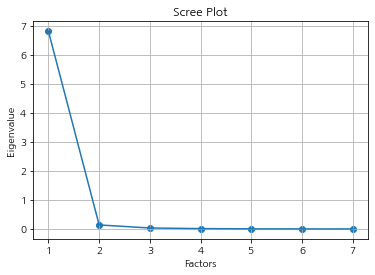

In [336]:
# df 설정 
df = ps_scaled_df

# Create factor analysis object and perform factor analysis
fa = FactorAnalyzer(n_factors=25, rotation=None)
fa.fit(df)

# Check Eigenvalues
ev, v = fa.get_eigenvalues()
ev

# Create scree plot using matplotlib
plt.scatter(range(1,df.shape[1]+1),ev)
plt.plot(range(1,df.shape[1]+1),ev)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()  # 2

### 성연령별 유동인구

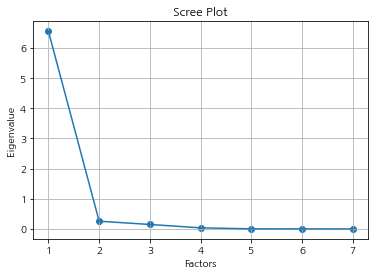

In [361]:
 # 행정동별 유동인구
# 데이터 프레임 설정 
scaled_df = trans21_tt_scaled

# Create factor analysis object and perform factor analysis
fa = FactorAnalyzer(n_factors=25, rotation=None)
fa.fit(scaled_df)

# Check Eigenvalues
ev, v = fa.get_eigenvalues()
ev

# Create scree plot using matplotlib
plt.scatter(range(1,scaled_df.shape[1]+1),ev)
plt.plot(range(1,scaled_df.shape[1]+1),ev)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()  # 2선택

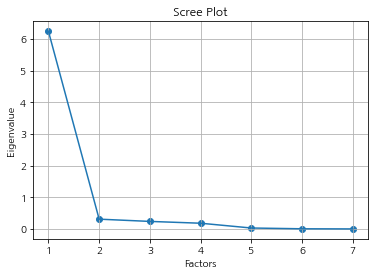

In [375]:
# 전체 유동인구
# df 설정 
df = trans21_t_scaled

# Create factor analysis object and perform factor analysis
fa = FactorAnalyzer(n_factors=25, rotation=None)
fa.fit(df)

# Check Eigenvalues
ev, v = fa.get_eigenvalues()
ev

# Create scree plot using matplotlib
plt.scatter(range(1,df.shape[1]+1),ev)
plt.plot(range(1,df.shape[1]+1),ev)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()  # 2

### 학교 데이터

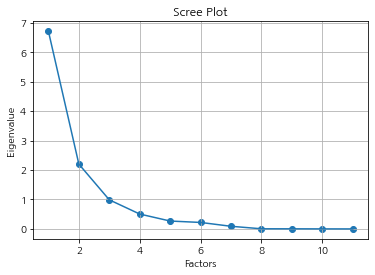

In [278]:
# Create factor analysis object and perform factor analysis
fa = FactorAnalyzer(n_factors=25, rotation=None)
fa.fit(scho_scaled_df)

# Check Eigenvalues
ev, v = fa.get_eigenvalues()
ev

# Create scree plot using matplotlib

plt.scatter(range(1,scho_scaled_df.shape[1]+1),ev)
plt.plot(range(1,scho_scaled_df.shape[1]+1),ev)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()  # 4선택

## EFA
요인분석할 데이터는 거주등록인구, 성연령별 유동인구, 학교 인구 만을 사용
- 문화시설데이터, 교통데이터, 산업 소비 데이터는 

### 거주등록인구

<AxesSubplot:>

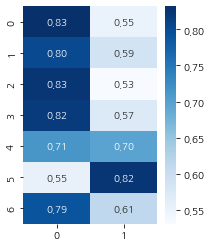

In [451]:
# df 설정  pop_ssub
df = ps_scaled_df

# Create factor analysis object and perform factor analysis using 4 factors

fa = FactorAnalyzer(n_factors=2,rotation='varimax') # 요인 4 
fa.fit(df)
efa_result = pd.DataFrame(fa.loadings_,index=df.columns)
efa_result

plt.figure(figsize=(3,4))
sns.heatmap(efa_result,cmap='Blues',annot=True, fmt='.2f') 

채택, 0요인은 0,1,2,3,6-> A 1요인은 4,5 ->B

In [460]:
ps_scaled_df.columns=['A0','A1','A2','A3','B4','B5','A6']
ps_scaled_df

,A0,A1,A2,A3,B4,B5,A6
0,0.338592,0.300834,0.285292,0.341379,0.224713,0.055343,0.278170
1,0.024414,0.034353,0.026553,0.043201,0.064631,0.076227,0.040740
2,0.213469,0.194797,0.222573,0.219063,0.226838,0.261399,0.220908
3,0.330471,0.261418,0.249731,0.346779,0.385373,0.427776,0.327432
4,0.234470,0.255163,0.171215,0.246324,0.287702,0.230653,0.234060
5,0.185331,0.195592,0.121336,0.205205,0.264129,0.263488,0.197365
6,0.432370,0.424245,0.308954,0.439037,0.485364,0.526395,0.426565
7,0.053122,0.150516,0.068365,0.077814,0.145783,0.167189,0.098015
8,0.072932,0.093229,0.101439,0.083019,0.075935,0.044553,0.080182
9,0.011897,0.024126,0.015528,0.019519,0.045020,0.117763,0.031607


<AxesSubplot:>

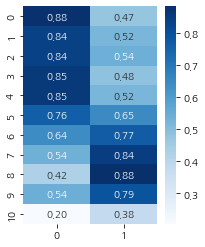

In [332]:
# df 설정 : pop_ssub2
df = ps_scaled_df

# Create factor analysis object and perform factor analysis using 4 factors

fa = FactorAnalyzer(n_factors=2,rotation='varimax') # 요인 4 
fa.fit(df)
efa_result = pd.DataFrame(fa.loadings_,index=df.columns)
efa_result

plt.figure(figsize=(3,4))
sns.heatmap(efa_result,cmap='Blues',annot=True, fmt='.2f') 

In [327]:
ps_scaled_df

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.278170,0.326442,0.350639,0.300834,0.285292,0.341379,0.224713,0.092761,0.021928,0.031345,0.034483,0.2
1,0.040740,0.020260,0.028533,0.034353,0.026553,0.043201,0.064631,0.080355,0.047053,0.203236,0.186207,0.2
2,0.220908,0.246026,0.181191,0.194797,0.222573,0.219063,0.226838,0.295871,0.207857,0.266936,0.303448,0.2
3,0.327432,0.306078,0.354656,0.261418,0.249731,0.346779,0.385373,0.406221,0.453175,0.558140,0.379310,0.6
4,0.234060,0.198649,0.269984,0.255163,0.171215,0.246324,0.287702,0.244029,0.233897,0.242669,0.151724,1.0
5,0.197365,0.139636,0.230635,0.195592,0.121336,0.205205,0.264129,0.268099,0.287803,0.265925,0.262069,0.2
6,0.426565,0.370494,0.493717,0.424245,0.308954,0.439037,0.485364,0.509906,0.572864,0.573306,0.462069,0.8
7,0.098015,0.035636,0.070457,0.150516,0.068365,0.077814,0.145783,0.178300,0.184559,0.163802,0.117241,0.8
8,0.080182,0.082909,0.063041,0.093229,0.101439,0.083019,0.075935,0.072579,0.043399,0.000000,0.013793,0.8
9,0.031607,0.007896,0.015863,0.024126,0.015528,0.019519,0.045020,0.098871,0.125628,0.278059,0.262069,0.4


### 성연령별 유동인구

<AxesSubplot:>

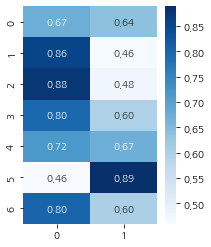

In [365]:
# 행정동별 유동인구
# df 설정 : trans21_tt_scaled
df = trans21_tt_scaled

# Create factor analysis object and perform factor analysis using 4 factors

fa = FactorAnalyzer(n_factors=2,rotation='varimax') # 요인 4 
fa.fit(df)
efa_result = pd.DataFrame(fa.loadings_,index=df.columns)
efa_result

plt.figure(figsize=(3,4))
sns.heatmap(efa_result,cmap='Blues',annot=True, fmt='.2f') 

<AxesSubplot:>

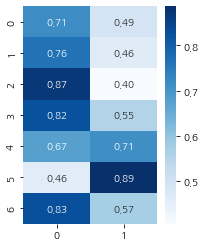

In [376]:
# 전체 유동인구
# df 설정 : trans21_t_scaled
df = trans21_t_scaled

# Create factor analysis object and perform factor analysis using 4 factors

fa = FactorAnalyzer(n_factors=2,rotation='varimax') # 요인 4 
fa.fit(df)
efa_result = pd.DataFrame(fa.loadings_,index=df.columns)
efa_result

plt.figure(figsize=(3,4))
sns.heatmap(efa_result,cmap='Blues',annot=True, fmt='.2f')  
# 유동인구의 경우, 행정동으로 묶어서 보는것은 통계오류를 일으킬수 있어 피벗하지않은 좌표단의 데이터를 이용

전체 유동인구 채택. 4,5-> B, 0,1,2,3,4,6-> A

In [463]:
trans21_t_scaled.columns=['A0','A1','A2','A3','B4','B5','A6']
trans21_t_scaled

,A0,A1,A2,A3,B4,B5,A6
0,0.000064,0.000060,0.000070,0.000124,0.000109,0.000083,0.000104
1,0.000195,0.000168,0.000100,0.000167,0.000285,0.000515,0.000255
2,0.001662,0.001460,0.001564,0.002771,0.003435,0.003042,0.002696
3,0.000334,0.000294,0.000337,0.000547,0.000437,0.000255,0.000466
4,0.015711,0.015676,0.017195,0.031516,0.030664,0.023506,0.026862
...,...,...,...,...,...,...,...
1058697,0.000000,0.000000,0.000005,0.000010,0.000006,0.000000,0.000005
1058698,0.000257,0.000212,0.000222,0.000333,0.000324,0.000298,0.000335
1058699,0.000104,0.000136,0.000138,0.000271,0.000433,0.000450,0.000276
1058700,0.000149,0.000169,0.000165,0.000286,0.000330,0.000290,0.000271


### 학교 데이터

<AxesSubplot:>

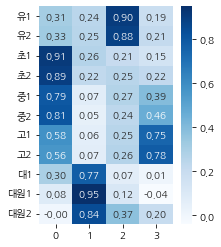

In [299]:
# Create factor analysis object and perform factor analysis using 4 factors

fa = FactorAnalyzer(n_factors=4,rotation='varimax') # 요인 4 
fa.fit(scho_scaled_df)
efa_result = pd.DataFrame(fa.loadings_,index=scho_scaled_df.columns)
efa_result

plt.figure(figsize=(3,4))
sns.heatmap(efa_result,cmap='Blues',annot=True, fmt='.2f') 

요인 0은 초등학교 학생수, 중학교수에 높은 요인 적재량을 가진다.

요인 1은 대학생수 및 대학원생수에 높은 요인 적재량을 가진다.

요인 2는 유치원생수에 높은 요인 적재량을 가진다.

요인 3은 고등학생수에 높은 요인 적재량을 가진다.

In [285]:
#  따라서 요인 4로 분석 
fa = FactorAnalyzer(n_factors=4,rotation='varimax') # 요인 4 
fa.fit(scho_scaled_df)

fa.get_factor_variance()
df1 = pd.DataFrame(fa.get_factor_variance())

df1.index = ['SS Loadings','Proportion Var','Cumulative Var']
df1

,0,1,2,3
SS Loadings,3.842063,2.451796,2.110020,1.721025
Proportion Var,0.349278,0.222891,0.191820,0.156457
Cumulative Var,0.349278,0.572169,0.763989,0.920446


<AxesSubplot:>

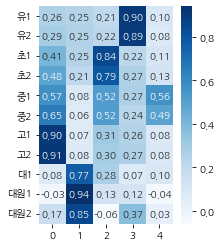

In [566]:
#유 초,중.고.대 5가지로

# Create factor analysis object and perform factor analysis using 4 factors

fa = FactorAnalyzer(n_factors=5,rotation='varimax') # 요인 4 
fa.fit(scho_scaled_df)
efa_result = pd.DataFrame(fa.loadings_,index=scho_scaled_df.columns)
efa_result

plt.figure(figsize=(3,4))
sns.heatmap(efa_result,cmap='Blues',annot=True, fmt='.2f') 

In [567]:
#  따라서 요인 5로 분석 
fa = FactorAnalyzer(n_factors=5,rotation='varimax') # 요인 4 
fa.fit(scho_scaled_df)

fa.get_factor_variance()
df1 = pd.DataFrame(fa.get_factor_variance())

df1.index = ['SS Loadings','Proportion Var','Cumulative Var']
df1

,0,1,2,3,4
SS Loadings,2.976191,2.450355,2.248931,2.144027,0.629207
Proportion Var,0.270563,0.222760,0.204448,0.194912,0.057201
Cumulative Var,0.270563,0.493322,0.697771,0.892682,0.949883


## 신뢰도 계수 확인

In [150]:
def CronbachAlpha(itemscores):
    itemscores = np.asarray(itemscores)
    itemvars = itemscores.var(axis=0, ddof = 1)
    tscores = itemscores.sum(axis=1)
    nitems = itemscores.shape[1]
    return (nitems/ (nitems-1))* (1-(itemvars.sum())/ tscores.var(ddof=1))

### 거주등록인구

In [461]:
# 요인끼리 묶어 주기 ps_scaled_df
factors = ['A','B'] # A 는 유소년층+청년층+노년층 빼고, B는 중장년층
factors_items_dict ={}
for factor in factors:
    factors_items_dict[factor] = [x for x in ps_scaled_df.columns if x[0]==factor]
    
print(factors_items_dict) # 확인

# 신뢰도 계수 확인
for key,value in factors_items_dict.items():
    print(key,':', CronbachAlpha(ps_scaled_df[value]))

{'A': ['A0', 'A1', 'A2', 'A3', 'A6'], 'B': ['B4', 'B5']}
A : 0.9976068317850719
B : 0.9844711086296141


### 성연령별 유동인구

In [464]:
# 요인끼리 묶어 주기 trans21_t_scaled
factors = ['A','B'] # A 는 유소년층+청년층+노년층 빼고, B는 중장년층
factors_items_dict ={}
for factor in factors:
    factors_items_dict[factor] = [x for x in trans21_t_scaled.columns if x[0]==factor]
    
print(factors_items_dict) # 확인

# 신뢰도 계수 확인
for key,value in factors_items_dict.items():
    print(key,':', CronbachAlpha(trans21_t_scaled[value]))

{'A': ['A0', 'A1', 'A2', 'A3', 'A6'], 'B': ['B4', 'B5']}
A : 0.9683909282767842
B : 0.9711997261465342


### 학교 데이터

In [568]:
# 요인끼리 묶어 주기
factors = ['유','초','중','고','대']
factors_items_dict ={}
for factor in factors:
    factors_items_dict[factor] = [x for x in scho_scaled_df.columns if x[0]==factor]
    
factors_items_dict # 여기서 '중'과 '초'는 하나로 묶임

{'유': ['유1', '유2'],
 '초': ['초1', '초2'],
 '중': ['중1', '중2'],
 '고': ['고1', '고2'],
 '대': ['대1', '대원1', '대원2']}

In [295]:
# 요인명 확인후 직접 조작
factors_items_dict_final ={}
factors_items_dict_final['유']= factors_items_dict['유']
factors_items_dict_final['초중']=factors_items_dict['초']+factors_items_dict['중']
factors_items_dict_final['고']= factors_items_dict['고']
factors_items_dict_final['대']= factors_items_dict['대']
factors_items_dict_final

{'유': ['유1', '유2'],
 '초중': ['초1', '초2', '중1', '중2'],
 '고': ['고1', '고2'],
 '대': ['대1', '대원1', '대원2']}

In [297]:
for key,value in factors_items_dict_final.items():
    print(key,':', CronbachAlpha(scho_scaled_df[value]))
# 4요인 모두 신뢰도 높음

유 : 0.9988020671817643
초중 : 0.9673929336140599
고 : 0.9972027786630917
대 : 0.8947106750554173


초등학생 400m 반경내 / 중학생 800m 반경내 의 평균 이동거리가 달라, 다르게 계산해 주기 위하여 변수를 유,초,중,고,대로 설정

In [298]:
# 5요인 모두 신뢰도 높음
for key,value in factors_items_dict.items():
    print(key,':', CronbachAlpha(scho_scaled_df[value]))

유 : 0.9988020671817643
초 : 0.9955188089150044
중 : 0.993833511880744
고 : 0.9972027786630917
대 : 0.8947106750554173


# 스코어링

## 스코어링할 후보지 데이터 로드 및 정제

In [467]:
proposed_site=pd.read_excel('./data/결과주소(layer5+건물x)_결과(행정동).xlsx', engine='openpyxl')

In [469]:
proposed_site['Unnamed: 0'].columns='index'

지번주소의 null값이 하나 존재함. 이를 표기하기 위하여 _PARCEL_AD의 null값을 직접 찾아서 기입해줌

- 도로명주소로 지번주소 찾는 Link
https://www.juso.go.kr/support/AddressMainSearch.do?firstSort=none&ablYn=N&aotYn=N&fillterHiddenValue=&searchKeyword=%EC%B6%A9%EC%B2%AD%EB%82%A8%EB%8F%84+%EC%95%84%EC%82%B0%EC%8B%9C+%EC%97%BC%EC%B9%98%EC%9D%8D+%ED%98%84%EB%8C%80%EB%A1%9C+96-20&dsgubuntext=&dscity1text=&dscounty1text=&dsemd1text=&dsri1text=&dssan1text=&dsrd_nm1text=&searchType=HSTRY&dssearchType1=road&dscity1=&dscounty1=&dsrd_nm_idx1=%EA%B0%80_%EB%82%98&dsrd_nm1=&dsma=&dssb=&dstown1=&dsri1=&dsbun1=&dsbun2=&dstown2=&dsbuilding1=

In [475]:
proposed_site['_PARCEL_AD'][proposed_site['_PARCEL_AD'].isnull()]='충청남도 아산시 염치읍 중방리 산11'

/tmp/ipykernel_20837/130363887.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  proposed_site['_PARCEL_AD'][proposed_site['_PARCEL_AD'].isnull()]='충청남도 아산시 염치읍 중방리 산11'


In [476]:
proposed_site.isnull().sum() # _PARCEL_AD 에 null 사라짐! 이를 

Unnamed: 0     0
경도             0
위도             0
A0             0
A1             0
A2             0
A3             0
A4             0
A5             0
A6             0
A7             0
A8             0
A9             0
A10            0
A11            0
A12            0
A13            0
A14            0
A15            0
A16            0
A17            0
A18            0
A19            0
A20            0
A21            0
A22            0
A23            0
A24            0
A25            0
A26            0
_PARCEL_AD     0
_ROAD_AD      30
행정동            0
dtype: int64

In [493]:
need_proposed_site = proposed_site[['Unnamed: 0','위도','경도','A11','A12','A14','A16','A18','A20','행정동','_PARCEL_AD']]

In [494]:
need_proposed_site.columns=['index','위도','경도','지목명','토지면적','용도지역명1','용도지역명2','토지이용상황','지형높이','행정동','지번주소']

In [495]:
need_proposed_site['용도지역명2'].value_counts()

지정되지않음       2190
자연녹지지역         24
계획관리지역         22
농림지역           17
일반공업지역          5
제1종일반주거지역       5
용도미지정           5
제2종일반주거지역       4
준공업지역           1
Name: 용도지역명2, dtype: int64

In [496]:
need_proposed_site['용도지역명1'].value_counts()

계획관리지역       999
농림지역         473
자연녹지지역       378
제2종일반주거지역    106
일반공업지역        92
용도미지정         90
일반상업지역        49
준주거지역         27
제2종전용주거지역     22
준공업지역         15
제3종일반주거지역     11
근린상업지역         6
제1종일반주거지역      5
Name: 용도지역명1, dtype: int64

In [497]:
# 용도지역명1을 기준으로 하고, 다음기준을 용도지역명2로 함 => 
need_proposed_site['용도지역명2'][need_proposed_site['용도지역명1']=='용도미지정'].value_counts()

# 용도지역명 1기준에 따르면, 용도미지정 지역중 a16으로 구분할 수 있는  값은 한개뿐임. 따라서 a14인 용도지역명 1만을 고려.

지정되지않음    89
계획관리지역     1
Name: 용도지역명2, dtype: int64

In [487]:
need_proposed_site

,index,위도,경도,지목명,토지면적,용도지역명1,용도지역명2,토지이용상황,지형높이,행정동,지번주소
0,0,36.782392,127.005628,대,1070.1,일반상업지역,지정되지않음,상업나지,평지,온양1동,충청남도 아산시 온천동 85-1
1,1,36.777425,127.005741,과수원,1491.0,제2종일반주거지역,지정되지않음,주거나지,평지,온양2동,충청남도 아산시 온천동 130-54
2,2,36.792304,126.999302,대,1363.0,제2종일반주거지역,지정되지않음,주거나지,평지,온양1동,충청남도 아산시 온천동 1087
3,3,36.793572,126.999076,주차장,975.0,자연녹지지역,지정되지않음,주거기타,평지,온양1동,충청남도 아산시 온천동 1098
4,4,36.785831,126.999372,대,1064.8,일반상업지역,지정되지않음,주거나지,평지,온양1동,충청남도 아산시 온천동 1338
...,...,...,...,...,...,...,...,...,...,...,...
2268,2268,36.812654,126.903331,과수원,3807.0,계획관리지역,지정되지않음,과수원,평지,신창면,충청남도 아산시 신창면 신곡리 48-5
2269,2269,36.812766,126.897723,임야,3362.0,계획관리지역,지정되지않음,과수원,완경사,신창면,충청남도 아산시 신창면 신곡리 산 82
2270,2270,36.798774,126.899822,대,998.0,계획관리지역,지정되지않음,주거나지,평지,신창면,충청남도 아산시 신창면 가내리 118
2271,2271,36.804541,126.886628,과수원,2940.0,계획관리지역,농림지역,과수원,평지,신창면,충청남도 아산시 신창면 가내리 613-8


In [498]:
temp = need_proposed_site
temp.drop('용도지역명2',axis=1,inplace=True)
pd.DataFrame(temp.iloc[0,:])

/tmp/ipykernel_20837/2378800707.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp.drop('용도지역명2',axis=1,inplace=True)


,0
index,0
위도,36.782392
경도,127.005628
지목명,대
토지면적,1070.1
용도지역명1,일반상업지역
토지이용상황,상업나지
지형높이,평지
행정동,온양1동
지번주소,충청남도 아산시 온천동 85-1


## 스코어링 요인별 데이터 로드 및 정제

In [499]:
need_proposed_site

,index,위도,경도,지목명,토지면적,용도지역명1,토지이용상황,지형높이,행정동,지번주소
0,0,36.782392,127.005628,대,1070.1,일반상업지역,상업나지,평지,온양1동,충청남도 아산시 온천동 85-1
1,1,36.777425,127.005741,과수원,1491.0,제2종일반주거지역,주거나지,평지,온양2동,충청남도 아산시 온천동 130-54
2,2,36.792304,126.999302,대,1363.0,제2종일반주거지역,주거나지,평지,온양1동,충청남도 아산시 온천동 1087
3,3,36.793572,126.999076,주차장,975.0,자연녹지지역,주거기타,평지,온양1동,충청남도 아산시 온천동 1098
4,4,36.785831,126.999372,대,1064.8,일반상업지역,주거나지,평지,온양1동,충청남도 아산시 온천동 1338
...,...,...,...,...,...,...,...,...,...,...
2268,2268,36.812654,126.903331,과수원,3807.0,계획관리지역,과수원,평지,신창면,충청남도 아산시 신창면 신곡리 48-5
2269,2269,36.812766,126.897723,임야,3362.0,계획관리지역,과수원,완경사,신창면,충청남도 아산시 신창면 신곡리 산 82
2270,2270,36.798774,126.899822,대,998.0,계획관리지역,주거나지,평지,신창면,충청남도 아산시 신창면 가내리 118
2271,2271,36.804541,126.886628,과수원,2940.0,계획관리지역,과수원,평지,신창면,충청남도 아산시 신창면 가내리 613-8


### 인구밀집도

#### 거주등록인구 점수화
행정동별로 거주등록인구의 수치 값은 같음 -> 행정동 레벨

In [556]:
# 거주등록인구 요인변수 2개  
pop_ssub['유소년ㆍ청년ㆍ노년 주민등록인구'] = pop_ssub['P1']+ pop_ssub['P2'] + pop_ssub['P3'] + pop_ssub['P6']
pop_ssub['중장년 주민등록인구'] = pop_ssub['P4']+ pop_ssub['P5']

거주등록인구= pop_ssub[['유소년ㆍ청년ㆍ노년 주민등록인구','중장년 주민등록인구','ymb_name','행정동중심_위도','행정동중심_경도']]
거주등록인구 # 행정동별 주민등록인구 수 요인변수

,유소년ㆍ청년ㆍ노년 주민등록인구,중장년 주민등록인구,ymb_name,행정동중심_위도,행정동중심_경도
35,16594.0,8316,탕정면,36.809157,127.068452
77,4167.0,2076,인주면,36.859881,126.885053
119,13950.0,6458,음봉면,36.858061,127.047785
161,18721.0,10062,온양6동,36.760953,127.015723
203,13935.0,7507,온양5동,36.775216,126.996027
245,11926.0,6631,온양4동,36.788478,126.984022
287,24062.0,12515,온양3동,36.783503,127.012858
329,7298.0,3448,온양2동,36.778414,127.003379
371,6539.0,2805,온양1동,36.787194,126.999478
413,4016.0,1509,영인면,36.885130,126.962584


#### 성연령별 유동인구 점수화
가장 가까운 좌표의 유동인구의 수를 점수화 -> 좌표 레벨

In [514]:
trans21_t[['coord_x','coord_y','T1','T2','T3','T4','T5','T6','T7']]

,coord_x,coord_y,T1,T2,T3,T4,T5,T6,T7
0,957783.991787,1.865379e+06,1.63,1.13,2.82,2.64,1.70,1.13,11.05
1,957783.991787,1.865579e+06,4.95,3.19,4.03,3.54,4.43,6.99,27.13
2,957783.991787,1.865629e+06,42.10,27.69,63.24,58.78,53.34,41.28,286.43
3,957783.991787,1.865679e+06,8.45,5.57,13.62,11.61,6.79,3.46,49.50
4,957783.991787,1.865779e+06,397.96,297.36,695.21,668.46,476.19,318.92,2854.10
...,...,...,...,...,...,...,...,...,...
1058697,957733.991787,1.866029e+06,0.00,0.00,0.21,0.22,0.10,0.00,0.53
1058698,957783.991787,1.864979e+06,6.50,4.02,8.96,7.06,5.03,4.04,35.61
1058699,957783.991787,1.865029e+06,2.64,2.58,5.57,5.75,6.73,6.11,29.38
1058700,957783.991787,1.865079e+06,3.77,3.21,6.66,6.06,5.12,3.94,28.76


In [513]:
trans21_t[['coord_x','coord_y','T1','T2','T3','T4','T5','T6','T7']].to_csv('성연령별유동인구.csv',encoding='utf-8-sig')

In [663]:
# 전처리된 유동인구데이터에 위경도전환한 데이터 
trans21_lg

,T1,T2,T3,T4,T5,T6,T7,geo2
0,1.63,1.13,2.82,2.64,1.70,1.13,11.05,"(36.78560969907209, 127.02686183503569)"
1,4.95,3.19,4.03,3.54,4.43,6.99,27.13,"(36.78741258830925, 127.02685075043442)"
2,42.10,27.69,63.24,58.78,53.34,41.28,286.43,"(36.787863310532515, 127.02684797913008)"
3,8.45,5.57,13.62,11.61,6.79,3.46,49.50,"(36.78831403272137, 127.0268452077641)"
4,397.96,297.36,695.21,668.46,476.19,318.92,2854.10,"(36.78921547699581, 127.02683966484727)"
...,...,...,...,...,...,...,...,...
1058697,0.00,0.00,0.21,0.22,0.10,0.00,0.53,"(36.791466856428706, 127.02626540351343)"
1058698,6.50,4.02,8.96,7.06,5.03,4.04,35.61,"(36.782003918946, 127.02688400128098)"
1058699,2.64,2.58,5.57,5.75,6.73,6.11,29.38,"(36.782454641582206, 127.02688123071593)"
1058700,3.77,3.21,6.66,6.06,5.12,3.94,28.76,"(36.782905364184, 127.02687846008928)"


In [664]:
# trans21_t의 coord_x, coord_y 를 위경도로 변환하여 trans21_lg로 불러옴
trans21_lg.columns = ['T1','T2','T3','T4','T5','T6','T7','좌표']
trans21_lg

,T1,T2,T3,T4,T5,T6,T7,좌표
0,1.63,1.13,2.82,2.64,1.70,1.13,11.05,"(36.78560969907209, 127.02686183503569)"
1,4.95,3.19,4.03,3.54,4.43,6.99,27.13,"(36.78741258830925, 127.02685075043442)"
2,42.10,27.69,63.24,58.78,53.34,41.28,286.43,"(36.787863310532515, 127.02684797913008)"
3,8.45,5.57,13.62,11.61,6.79,3.46,49.50,"(36.78831403272137, 127.0268452077641)"
4,397.96,297.36,695.21,668.46,476.19,318.92,2854.10,"(36.78921547699581, 127.02683966484727)"
...,...,...,...,...,...,...,...,...
1058697,0.00,0.00,0.21,0.22,0.10,0.00,0.53,"(36.791466856428706, 127.02626540351343)"
1058698,6.50,4.02,8.96,7.06,5.03,4.04,35.61,"(36.782003918946, 127.02688400128098)"
1058699,2.64,2.58,5.57,5.75,6.73,6.11,29.38,"(36.782454641582206, 127.02688123071593)"
1058700,3.77,3.21,6.66,6.06,5.12,3.94,28.76,"(36.782905364184, 127.02687846008928)"


In [665]:
# 유동인구 요인변수 2개  
trans21_lg['유소년ㆍ청년ㆍ노년 유동인구'] = trans21_lg['T1']+ trans21_lg['T2'] + trans21_lg['T3'] + trans21_lg['T6']
trans21_lg['중장년 유동인구'] = trans21_lg['T4']+ trans21_lg['T5']

유동인구= trans21_lg[['유소년ㆍ청년ㆍ노년 유동인구','중장년 유동인구','좌표']]
유동인구 # 행정동별 주민등록인구 수 요인변수

,유소년ㆍ청년ㆍ노년 유동인구,중장년 유동인구,좌표
0,6.71,4.34,"(36.78560969907209, 127.02686183503569)"
1,19.16,7.97,"(36.78741258830925, 127.02685075043442)"
2,174.31,112.12,"(36.787863310532515, 127.02684797913008)"
3,31.10,18.40,"(36.78831403272137, 127.0268452077641)"
4,1709.45,1144.65,"(36.78921547699581, 127.02683966484727)"
...,...,...,...
1058697,0.21,0.32,"(36.791466856428706, 127.02626540351343)"
1058698,23.52,12.09,"(36.782003918946, 127.02688400128098)"
1058699,16.90,12.48,"(36.782454641582206, 127.02688123071593)"
1058700,17.58,11.18,"(36.782905364184, 127.02687846008928)"


### 접근성 및 이용자 편의성

#### 평균이동 반경내 지하철 정거장
승하차 인원수 : https://data.seoul.go.kr/dataList/OA-12914/S/1/datasetView.do#


In [522]:
train[['지하철역명','위도','경도']] #  거리반경 내 지하철역명(unique함) 의 수

,지하철역명,위도,경도
0,아산역,36.792047,127.104115
1,탕정역,36.787722,127.084448
2,배방역,36.777563,127.052905
3,온양온천역,36.780468,127.003451
4,신창역,36.769485,126.949922


#### 평균이동반경내 버스 정거장

In [526]:
bus[['정류장아이디','위도','경도']] # 거리반경 내 정류장 아이디(unique함) 의 수

,정류장아이디,위도,경도
0,ASB288000226,36.818911,126.898581
1,ASB288000228,36.818911,126.898581
2,ASB288000229,36.818911,126.898581
3,ASB288000230,36.813995,126.924297
4,ASB288000232,36.813995,126.924297
...,...,...,...
1820,ASB288010805,36.770198,127.095808
1821,ASB288010806,36.766700,127.071893
1822,ASB288010807,36.766700,127.071893
1823,ASB288010808,36.805861,127.034479


### 랜드마크 효과성

####  행정동별 소비 발생 상점수
행정동별 값은 같음 -> 행정동 레벨

In [534]:
# 행정동별 소비상점수
pd.DataFrame(card21_frcs['FRCS_CNT'])

,FRCS_CNT
FRCS_DONG_NM,
도고면,16719
둔포면,126203
배방읍,213841
선장면,7991
송악면,10342
신창면,82773
염치읍,32844
영인면,25082
온양1동,195005


#### 평균이동 반경내 학급 및 학생수

In [550]:
scho_scaled_df

,유1,유2,초1,초2,중1,중2,고1,고2,대1,대원1,대원2
0,0.023256,0.018991,0.000000,0.006757,0.100000,0.030371,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.395349,0.352686,0.428571,0.353808,0.283333,0.221597,0.358974,0.258510,0.000000,0.000000,0.000000
2,1.000000,1.000000,0.825893,0.861026,0.933333,0.896513,0.923077,1.000000,0.835264,0.998788,1.000000
3,1.000000,1.000000,0.825893,0.861026,0.933333,0.896513,0.923077,1.000000,0.000000,0.000000,0.000000
4,0.023256,0.018991,0.089286,0.133292,0.200000,0.130484,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.116279,0.127509,0.714286,0.583333,0.366667,0.258718,0.000000,0.000000,0.564290,1.000000,0.231233
6,0.139535,0.154639,0.125000,0.116708,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.069767,0.046120,0.017857,0.000000,0.233333,0.093363,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.046512,0.035269,0.464286,0.456388,0.900000,0.949381,0.858974,0.925023,0.000000,0.000000,0.000000
9,0.011628,0.010852,0.392857,0.371622,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [549]:
# 세부요인별로 분산이 다르기때문에 min-max 스케일한 값의 평균을 대표인수로 설정 # 유, 초중, 고, 대
학교 = pd.DataFrame()
학교['유']= (scho_scaled_df['유1']+scho_scaled_df['유2'])/2
학교['초중']= (scho_scaled_df['초1']+scho_scaled_df['초2']+scho_scaled_df['중1']+scho_scaled_df['중2'])/4
학교['고']= (scho_scaled_df['고1']+scho_scaled_df['고2'])/2
학교['대']= (scho_scaled_df['대1']+scho_scaled_df['대원1']+scho_scaled_df['대원2'])/2

,유
0,0.021123
1,0.374017
2,1.000000
3,1.000000
4,0.021123
5,0.121894
6,0.147087
7,0.057944
8,0.040890
9,0.011240


#### 평균이동반경내 문화시설 수
평균이동 반경내 수 -> 위경도 좌표레벨

In [546]:
shop[['상가업소번호','위도','경도']]# 거리반경 내 상가업소(unique함) 의 수 

,상가업소번호,위도,경도
0,28487726,36.781602,127.005505
1,22942740,36.781396,127.001374
2,28507428,36.778587,127.059126
3,21662036,36.776188,126.995997
4,20763901,36.783447,127.093092
...,...,...,...
12920,18450125,36.897643,126.993690
12921,18453647,36.789295,127.081303
12922,18457530,36.770046,126.938323
12923,18460201,36.785832,127.086857


## 요인별 스코어링

In [574]:
! pip install haversine

In [575]:
from haversine import haversine

# 위경도 입력
Seoul = (37.541, 126.986)  #Latitude, Longitude
Toronto = (43.65, -79.38)

# 거리 계산
haversine(Seoul, Toronto, unit = 'm')

10603855.192138562

In [584]:
# 후보지 데이터에 좌표 칼럼 추가
need_proposed_site['좌표']=''
for i in range(len(need_proposed_site)):
    need_proposed_site['좌표'][i] = (need_proposed_site['위도'][i],need_proposed_site['경도'][i])

/tmp/ipykernel_20837/3088610852.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  need_proposed_site['좌표']=''
/tmp/ipykernel_20837/3088610852.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  need_proposed_site['좌표'][i] = (need_proposed_site['위도'][i],need_proposed_site['경도'][i])


In [585]:
need_proposed_site

,index,위도,경도,지목명,토지면적,용도지역명1,토지이용상황,지형높이,행정동,지번주소,좌표
0,0,36.782392,127.005628,대,1070.1,일반상업지역,상업나지,평지,온양1동,충청남도 아산시 온천동 85-1,"(36.78239195, 127.0056275)"
1,1,36.777425,127.005741,과수원,1491.0,제2종일반주거지역,주거나지,평지,온양2동,충청남도 아산시 온천동 130-54,"(36.77742498, 127.0057406)"
2,2,36.792304,126.999302,대,1363.0,제2종일반주거지역,주거나지,평지,온양1동,충청남도 아산시 온천동 1087,"(36.79230426, 126.9993017)"
3,3,36.793572,126.999076,주차장,975.0,자연녹지지역,주거기타,평지,온양1동,충청남도 아산시 온천동 1098,"(36.79357194, 126.9990764)"
4,4,36.785831,126.999372,대,1064.8,일반상업지역,주거나지,평지,온양1동,충청남도 아산시 온천동 1338,"(36.78583083, 126.9993721)"
...,...,...,...,...,...,...,...,...,...,...,...
2268,2268,36.812654,126.903331,과수원,3807.0,계획관리지역,과수원,평지,신창면,충청남도 아산시 신창면 신곡리 48-5,"(36.81265381, 126.903331)"
2269,2269,36.812766,126.897723,임야,3362.0,계획관리지역,과수원,완경사,신창면,충청남도 아산시 신창면 신곡리 산 82,"(36.81276628, 126.8977233)"
2270,2270,36.798774,126.899822,대,998.0,계획관리지역,주거나지,평지,신창면,충청남도 아산시 신창면 가내리 118,"(36.79877381, 126.8998221)"
2271,2271,36.804541,126.886628,과수원,2940.0,계획관리지역,과수원,평지,신창면,충청남도 아산시 신창면 가내리 613-8,"(36.80454108, 126.8866282)"


### 인구밀집도

#### 거주등록인구

In [601]:
거주등록인구.reset_index(inplace=True)
거주등록인구

,index,유소년ㆍ청년ㆍ노년 주민등록인구,중장년 주민등록인구,ymb_name,행정동중심_위도,행정동중심_경도
0,35,16594.0,8316,탕정면,36.809157,127.068452
1,77,4167.0,2076,인주면,36.859881,126.885053
2,119,13950.0,6458,음봉면,36.858061,127.047785
3,161,18721.0,10062,온양6동,36.760953,127.015723
4,203,13935.0,7507,온양5동,36.775216,126.996027
5,245,11926.0,6631,온양4동,36.788478,126.984022
6,287,24062.0,12515,온양3동,36.783503,127.012858
7,329,7298.0,3448,온양2동,36.778414,127.003379
8,371,6539.0,2805,온양1동,36.787194,126.999478
9,413,4016.0,1509,영인면,36.885130,126.962584


In [590]:
temp = 거주등록인구.iloc[:,0:2]
scaler.fit(temp)
ps_scaled = scaler.transform(temp)
ps_scaled_df = pd.DataFrame(ps_scaled)

In [591]:
ps_scaled_df #유소년ㆍ청년ㆍ노년 주민등록인구 #중장년 주민등록인구

,0,1
0,0.270265,0.294429
1,0.035350,0.051825
2,0.220284,0.222192
3,0.310473,0.362311
4,0.220000,0.262976
5,0.182023,0.228918
6,0.411437,0.457680
7,0.094537,0.105167
8,0.080189,0.080168
9,0.032495,0.029781


In [622]:
need_proposed_site['거주등록인구_score'] =''
for i in range(len(거주등록인구)):
    need_proposed_site['거주등록인구_score'][need_proposed_site['행정동']== 거주등록인구['ymb_name'][i]] = (ps_scaled_df[0][i]+ps_scaled_df[1][i])/2

/tmp/ipykernel_20837/2404623289.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  need_proposed_site['거주등록인구_score'] =''
/tmp/ipykernel_20837/2404623289.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  need_proposed_site['거주등록인구_score'][need_proposed_site['행정동']== 거주등록인구['ymb_name'][i]] = (ps_scaled_df[0][i]+ps_scaled_df[1][i])/2


In [640]:
# 다 실 수를 적어놓은 다음, 스케일링 값을 적자. 해석을 용이하게 하기 위함.
need_proposed_site['거주등록인구수_A'] =''
need_proposed_site['거주등록인구수_B'] =''
for i in tqdm(range(len(거주등록인구))):
    need_proposed_site['거주등록인구수_A'][need_proposed_site['행정동']== 거주등록인구['ymb_name'][i]] = 거주등록인구['유소년ㆍ청년ㆍ노년 주민등록인구'][i]
    need_proposed_site['거주등록인구수_B'][need_proposed_site['행정동']== 거주등록인구['ymb_name'][i]] = 거주등록인구['중장년 주민등록인구'][i]

/tmp/ipykernel_20837/2995690127.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  need_proposed_site['거주등록인구수_A'] =''
/tmp/ipykernel_20837/2995690127.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  need_proposed_site['거주등록인구수_B'] =''
  0%|          | 0/17 [00:00<?, ?it/s]/tmp/ipykernel_20837/2995690127.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

In [648]:
need_proposed_site.iloc[:,-2:]

,거주등록인구수_A,거주등록인구수_B
0,6539.0,2805
1,7298.0,3448
2,6539.0,2805
3,6539.0,2805
4,6539.0,2805
...,...,...
2268,12956.0,6688
2269,12956.0,6688
2270,12956.0,6688
2271,12956.0,6688


In [646]:
temp = need_proposed_site.iloc[:,-2:]
scaler.fit(temp)
ps_scaled = scaler.transform(temp)
ps_scaled_df = pd.DataFrame(ps_scaled)
ps_scaled_df # 확인 이후에 스케일링을 한번에 취해주어도 문제 없음

,0,1
0,0.080189,0.080168
1,0.094537,0.105167
2,0.080189,0.080168
3,0.080189,0.080168
4,0.080189,0.080168
...,...,...
2268,0.201493,0.231134
2269,0.201493,0.231134
2270,0.201493,0.231134
2271,0.201493,0.231134


#### 500m이내 유동인구

In [757]:
유동인구

,유소년ㆍ청년ㆍ노년 유동인구,중장년 유동인구,좌표
0,6.71,4.34,"(36.78560969907209, 127.02686183503569)"
1,19.16,7.97,"(36.78741258830925, 127.02685075043442)"
2,174.31,112.12,"(36.787863310532515, 127.02684797913008)"
3,31.10,18.40,"(36.78831403272137, 127.0268452077641)"
4,1709.45,1144.65,"(36.78921547699581, 127.02683966484727)"
...,...,...,...
1058697,0.21,0.32,"(36.791466856428706, 127.02626540351343)"
1058698,23.52,12.09,"(36.782003918946, 127.02688400128098)"
1058699,16.90,12.48,"(36.782454641582206, 127.02688123071593)"
1058700,17.58,11.18,"(36.782905364184, 127.02687846008928)"


In [ ]:
temp=0
for i in range(len(유동인구[]))

* 유동인구 좌표 너무 오래걸려서 일단 행정동으로 먼저 확인

In [780]:
trans21_tt['유소년ㆍ청년ㆍ노년 유동인구'] = trans21_tt['T1']+ trans21_tt['T2'] + trans21_tt['T3'] + trans21_tt['T6']
trans21_tt['중장년 유동인구'] = trans21_tt['T4']+ trans21_tt['T5']
행정동별유동인구= trans21_tt[['유소년ㆍ청년ㆍ노년 유동인구','중장년 유동인구']]
행정동별유동인구.reset_index(inplace = True)
행정동별유동인구

,adong_nm,유소년ㆍ청년ㆍ노년 유동인구,중장년 유동인구
0,도고면,6758542.00,4795046.07
1,둔포면,27375336.78,20762301.31
2,배방읍,93520999.43,48414470.18
3,선장면,4576325.36,3436935.31
4,송악면,4694911.02,3507183.50
5,신창면,31951294.84,14668700.17
6,염치읍,13909352.62,10858495.05
7,영인면,10819147.83,9231627.02
8,온양1동,17935408.78,10359335.76
9,온양2동,15056941.54,8289300.34


In [781]:
# 다 실 수를 적어놓은 다음, 스케일링 값을 적자. 해석을 용이하게 하기 위함.
need_proposed_site['유소년ㆍ청년ㆍ노년 유동인구수'] = 0
need_proposed_site['중장년 유동인구수'] = 0
for i in tqdm(range(len(행정동별유동인구))):
    need_proposed_site['유소년ㆍ청년ㆍ노년 유동인구수'][need_proposed_site['행정동']== 행정동별유동인구['adong_nm'][i]] = 행정동별유동인구['유소년ㆍ청년ㆍ노년 유동인구'][i]
    need_proposed_site['중장년 유동인구수'][need_proposed_site['행정동']== 행정동별유동인구['adong_nm'][i]] = 행정동별유동인구['중장년 유동인구'][i]

  0%|          | 0/17 [00:00<?, ?it/s]/tmp/ipykernel_20837/3427732765.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  need_proposed_site['유소년ㆍ청년ㆍ노년 유동인구수'][need_proposed_site['행정동']== 행정동별유동인구['adong_nm'][i]] = 행정동별유동인구['유소년ㆍ청년ㆍ노년 유동인구'][i]
/tmp/ipykernel_20837/3427732765.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  need_proposed_site['중장년 유동인구수'][need_proposed_site['행정동']== 행정동별유동인구['adong_nm'][i]] = 행정동별유동인구['중장년 유동인구'][i]
100%|██████████| 17/17 [00:00<00:00, 234.86it/s]


In [782]:
need_proposed_site

,index,위도,경도,지목명,토지면적,용도지역명1,토지이용상황,지형높이,행정동,지번주소,...,반경내 고등학교수,반경내 고등학생수,반경내 고등학교학급수,반경내 석사생수,반경내 박사생수,반경내 학사생수,유치원학급수,유치원생수,유소년ㆍ청년ㆍ노년 유동인구수,중장년 유동인구수
0,0,36.782392,127.005628,대,1070.1,일반상업지역,상업나지,평지,온양1동,충청남도 아산시 온천동 85-1,...,15,14857,522,0,0,0,4,60,17935408.78,10359335.76
1,1,36.777425,127.005741,과수원,1491.0,제2종일반주거지역,주거나지,평지,온양2동,충청남도 아산시 온천동 130-54,...,9,8890,324,0,0,0,4,60,15056941.54,8289300.34
2,2,36.792304,126.999302,대,1363.0,제2종일반주거지역,주거나지,평지,온양1동,충청남도 아산시 온천동 1087,...,9,8998,304,0,0,0,4,60,17935408.78,10359335.76
3,3,36.793572,126.999076,주차장,975.0,자연녹지지역,주거기타,평지,온양1동,충청남도 아산시 온천동 1098,...,9,8998,304,0,0,0,4,60,17935408.78,10359335.76
4,4,36.785831,126.999372,대,1064.8,일반상업지역,주거나지,평지,온양1동,충청남도 아산시 온천동 1338,...,9,8998,304,0,0,0,4,60,17935408.78,10359335.76
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2268,2268,36.812654,126.903331,과수원,3807.0,계획관리지역,과수원,평지,신창면,충청남도 아산시 신창면 신곡리 48-5,...,0,0,0,0,0,0,1,20,31951294.84,14668700.17
2269,2269,36.812766,126.897723,임야,3362.0,계획관리지역,과수원,완경사,신창면,충청남도 아산시 신창면 신곡리 산 82,...,0,0,0,0,0,0,1,20,31951294.84,14668700.17
2270,2270,36.798774,126.899822,대,998.0,계획관리지역,주거나지,평지,신창면,충청남도 아산시 신창면 가내리 118,...,0,0,0,0,0,0,1,20,31951294.84,14668700.17
2271,2271,36.804541,126.886628,과수원,2940.0,계획관리지역,과수원,평지,신창면,충청남도 아산시 신창면 가내리 613-8,...,0,0,0,0,0,0,1,20,31951294.84,14668700.17


### 접근성

#### 500m 이내 지하철 수

In [627]:
from tqdm import tqdm
# 후보지 데이터에 좌표 칼럼 추가
train['좌표']=''
for i in tqdm(range(len(train))):
    train['좌표'][i] = (train['위도'][i],train['경도'][i])

  0%|          | 0/5 [00:00<?, ?it/s]/tmp/ipykernel_20837/2431272306.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['좌표'][i] = (train['위도'][i],train['경도'][i])
100%|██████████| 5/5 [00:00<00:00, 49.21it/s]


In [658]:
need_proposed_site['지하철수'] = 0
for i in tqdm(range(len(need_proposed_site))):
    for j in range(len(train)):
        if haversine(need_proposed_site['좌표'][i],train['좌표'][j], unit = 'm')  <= 500 :
             need_proposed_site['지하철수'][i] += 1

/tmp/ipykernel_20837/210424492.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  need_proposed_site['지하철수'] = 0
  0%|          | 0/2273 [00:00<?, ?it/s]/tmp/ipykernel_20837/210424492.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  need_proposed_site['지하철수'][i] += 1
100%|██████████| 2273/2273 [00:01<00:00, 2111.46it/s]


#### 500m 이내 버스정거장 수

In [630]:
bus['좌표']=''
for i in tqdm(range(len(bus))):
    bus['좌표'][i] = (bus['위도'][i],bus['경도'][i])

  0%|          | 0/1825 [00:00<?, ?it/s]/tmp/ipykernel_20837/1921846476.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bus['좌표'][i] = (bus['위도'][i],bus['경도'][i])
100%|██████████| 1825/1825 [00:21<00:00, 85.08it/s]


In [637]:
need_proposed_site['버스정거장수'] = 0
for i in tqdm(range(len(need_proposed_site))):
    for j in range(len(bus)):
        if haversine(need_proposed_site['좌표'][i],bus['좌표'][j], unit = 'm')  <= 500 :
             need_proposed_site['버스정거장수'][i] += 1

/tmp/ipykernel_20837/1586087672.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  need_proposed_site['버스정거장수'] = 0
  0%|          | 0/2273 [00:00<?, ?it/s]/tmp/ipykernel_20837/1586087672.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  need_proposed_site['버스정거장수'][i] += 1
100%|██████████| 2273/2273 [03:58<00:00,  9.54it/s]


In [659]:
need_proposed_site

,index,위도,경도,지목명,토지면적,용도지역명1,토지이용상황,지형높이,행정동,지번주소,좌표,거주등록인구_score,버스정거장수,거주등록인구수_A,거주등록인구수_B,지하철수
0,0,36.782392,127.005628,대,1070.1,일반상업지역,상업나지,평지,온양1동,충청남도 아산시 온천동 85-1,"(36.78239195, 127.0056275)",0.080178,37,6539.0,2805,1
1,1,36.777425,127.005741,과수원,1491.0,제2종일반주거지역,주거나지,평지,온양2동,충청남도 아산시 온천동 130-54,"(36.77742498, 127.0057406)",0.099852,0,7298.0,3448,1
2,2,36.792304,126.999302,대,1363.0,제2종일반주거지역,주거나지,평지,온양1동,충청남도 아산시 온천동 1087,"(36.79230426, 126.9993017)",0.080178,0,6539.0,2805,0
3,3,36.793572,126.999076,주차장,975.0,자연녹지지역,주거기타,평지,온양1동,충청남도 아산시 온천동 1098,"(36.79357194, 126.9990764)",0.080178,0,6539.0,2805,0
4,4,36.785831,126.999372,대,1064.8,일반상업지역,주거나지,평지,온양1동,충청남도 아산시 온천동 1338,"(36.78583083, 126.9993721)",0.080178,37,6539.0,2805,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2268,2268,36.812654,126.903331,과수원,3807.0,계획관리지역,과수원,평지,신창면,충청남도 아산시 신창면 신곡리 48-5,"(36.81265381, 126.903331)",0.216314,0,12956.0,6688,0
2269,2269,36.812766,126.897723,임야,3362.0,계획관리지역,과수원,완경사,신창면,충청남도 아산시 신창면 신곡리 산 82,"(36.81276628, 126.8977233)",0.216314,0,12956.0,6688,0
2270,2270,36.798774,126.899822,대,998.0,계획관리지역,주거나지,평지,신창면,충청남도 아산시 신창면 가내리 118,"(36.79877381, 126.8998221)",0.216314,0,12956.0,6688,0
2271,2271,36.804541,126.886628,과수원,2940.0,계획관리지역,과수원,평지,신창면,충청남도 아산시 신창면 가내리 613-8,"(36.80454108, 126.8866282)",0.216314,0,12956.0,6688,0


### 랜드마크 효과성 

#### 행정동별 소비상점개수  
card21_frcs['FRCS_CNT']

In [679]:
card21_frcs.reset_index(inplace=True) #card21_frcs가 pivotable이라 pd.DataFrame형식으로 바꾸어줌

In [680]:
card21_frcs

,FRCS_DONG_NM,TEEN_BELOW_USE_NOCS,TEEN_USE_NOCS,TWT_USE_NOCS,TRT_USE_NOCS,FRT_USE_NOCS,FFT_USE_NOCS,SXT_USE_NOCS,SVT_ABV_USE_NOCS,TEEN_BELOW_USE_AMT,TEEN_USE_AMT,TWT_USE_AMT,TRT_USE_AMT,FRT_USE_AMT,FFT_USE_AMT,SXT_USE_AMT,SVT_ABV_USE_AMT,FRCS_CNT,행정동중심_위도,행정동중심_경도
0,도고면,0,0.0,3261.0,8169.0,9396.0,9426.0,6174.0,2099.0,0,185090,110626501,306214277,445086969,528031474,451437162,172848433,16719,2.632303e+05,9.087115e+05
1,둔포면,0,4152.0,162919.0,480428.0,398035.0,192180.0,78985.0,15437.0,0,27525780,2718408862,10118635966,9380614125,5912156206,3159479411,807821984,126203,9.881670e+05,3.406575e+06
2,배방읍,0,15959.0,241771.0,512194.0,600538.0,285879.0,100774.0,27737.0,0,114457382,3634746170,14503143930,15789718160,7669522494,3194283877,977462120,213841,1.261213e+06,4.354570e+06
3,선장면,0,0.0,2461.0,5975.0,5532.0,4579.0,3202.0,2409.0,0,0,79840289,233070963,265576327,430032800,506470635,362814598,7991,1.574852e+05,5.433856e+05
4,송악면,0,0.0,352.0,2332.0,6047.0,7043.0,4336.0,1830.0,0,72100,19325820,67825191,190036745,268095847,283188225,149472470,10342,1.423618e+05,4.917819e+05
5,신창면,0,985.0,151184.0,254851.0,267621.0,145616.0,42116.0,7448.0,0,12237850,1859839510,4582256144,5564021059,3742828615,1494749987,470600740,82773,7.814034e+05,2.696680e+06
6,염치읍,0,102.0,6144.0,22984.0,37431.0,24356.0,11208.0,2911.0,0,1174945,168448197,696448836,1427663952,1494391781,1040864294,319895712,32844,4.641107e+05,1.601469e+06
7,영인면,0,8.0,5648.0,18355.0,23096.0,22708.0,14269.0,4726.0,0,219220,170649897,722335555,1599149545,1425597444,1119809835,369327269,25082,4.028936e+05,1.389379e+06
8,온양1동,0,1801.0,60183.0,134582.0,175011.0,148206.0,74602.0,21122.0,0,29902090,1342097901,3343211631,4730808074,4706038892,2881847474,1072973706,195005,1.813485e+06,6.259228e+06
9,온양2동,0,288.0,27101.0,50783.0,63038.0,56822.0,24124.0,5741.0,0,10339010,584006630,1294962863,1712665401,1602834379,878862407,271607301,67620,7.822156e+05,2.700291e+06


In [681]:
# 다 실 수를 적어놓은 다음, 스케일링 값을 적자. 해석을 용이하게 하기 위함.
need_proposed_site['산업시설수'] = 0
for i in tqdm(range(len(card21_frcs))):
    need_proposed_site['산업시설수'][need_proposed_site['행정동']== card21_frcs['FRCS_DONG_NM'][i]] = card21_frcs['FRCS_CNT'][i]

/tmp/ipykernel_20837/2679193514.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  need_proposed_site['산업시설수'] =''
  0%|          | 0/17 [00:00<?, ?it/s]/tmp/ipykernel_20837/2679193514.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  need_proposed_site['산업시설수'][need_proposed_site['행정동']== card21_frcs['FRCS_DONG_NM'][i]] = card21_frcs['FRCS_CNT'][i]
100%|██████████| 17/17 [00:00<00:00, 37.65it/s]


In [682]:
need_proposed_site

,index,위도,경도,지목명,토지면적,용도지역명1,토지이용상황,지형높이,행정동,지번주소,좌표,거주등록인구_score,버스정거장수,거주등록인구수_A,거주등록인구수_B,지하철수,산업시설수
0,0,36.782392,127.005628,대,1070.1,일반상업지역,상업나지,평지,온양1동,충청남도 아산시 온천동 85-1,"(36.78239195, 127.0056275)",0.080178,37,6539.0,2805,1,195005
1,1,36.777425,127.005741,과수원,1491.0,제2종일반주거지역,주거나지,평지,온양2동,충청남도 아산시 온천동 130-54,"(36.77742498, 127.0057406)",0.099852,0,7298.0,3448,1,67620
2,2,36.792304,126.999302,대,1363.0,제2종일반주거지역,주거나지,평지,온양1동,충청남도 아산시 온천동 1087,"(36.79230426, 126.9993017)",0.080178,0,6539.0,2805,0,195005
3,3,36.793572,126.999076,주차장,975.0,자연녹지지역,주거기타,평지,온양1동,충청남도 아산시 온천동 1098,"(36.79357194, 126.9990764)",0.080178,0,6539.0,2805,0,195005
4,4,36.785831,126.999372,대,1064.8,일반상업지역,주거나지,평지,온양1동,충청남도 아산시 온천동 1338,"(36.78583083, 126.9993721)",0.080178,37,6539.0,2805,0,195005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2268,2268,36.812654,126.903331,과수원,3807.0,계획관리지역,과수원,평지,신창면,충청남도 아산시 신창면 신곡리 48-5,"(36.81265381, 126.903331)",0.216314,0,12956.0,6688,0,82773
2269,2269,36.812766,126.897723,임야,3362.0,계획관리지역,과수원,완경사,신창면,충청남도 아산시 신창면 신곡리 산 82,"(36.81276628, 126.8977233)",0.216314,0,12956.0,6688,0,82773
2270,2270,36.798774,126.899822,대,998.0,계획관리지역,주거나지,평지,신창면,충청남도 아산시 신창면 가내리 118,"(36.79877381, 126.8998221)",0.216314,0,12956.0,6688,0,82773
2271,2271,36.804541,126.886628,과수원,2940.0,계획관리지역,과수원,평지,신창면,충청남도 아산시 신창면 가내리 613-8,"(36.80454108, 126.8866282)",0.216314,0,12956.0,6688,0,82773


#### 학급 및 학생 수

In [700]:
schol1['좌표']=''
for i in tqdm(range(len(schol1))):
    schol1['좌표'][i] = (schol1['위도'][i],schol1['경도'][i])
    
schol2['좌표']=''
for i in tqdm(range(len(schol2))):
    schol2['좌표'][i] = (schol2['위도'][i],schol2['경도'][i])
    
schol3['좌표']=''
for i in tqdm(range(len(schol3))):
    schol3['좌표'][i] = (schol3['위도'][i],schol3['경도'][i])
    
schol4['좌표']=''
for i in tqdm(range(len(schol4))):
    schol4['좌표'][i] = (schol4['위도'][i],schol4['경도'][i])

schol5['좌표']=''
for i in tqdm(range(len(schol5))):
    schol5['좌표'][i] = (schol5['Latitude'][i],schol5['Longitude'][i])
    
schol6['좌표']=''
for i in tqdm(range(len(schol6))):
    schol6['좌표'][i] = (schol6['Latitude'][i],schol6['Longitude'][i])


  0%|          | 0/60 [00:00<?, ?it/s]/tmp/ipykernel_20837/3179125084.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  schol1['좌표'][i] = (schol1['위도'][i],schol1['경도'][i])
  0%|          | 0/46 [00:00<?, ?it/s]/tmp/ipykernel_20837/3179125084.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  schol2['좌표'][i] = (schol2['위도'][i],schol2['경도'][i])
  0%|          | 0/19 [00:00<?, ?it/s]/tmp/ipykernel_20837/3179125084.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

In [754]:
# 유치원
# 유치원생 연구 결과 유치원생의 이동은 도보와 차량 비율이 차이가 없으며, 두 기준에 대해 값이 너무 달라, 행정동에 같은 값을 매칭

schol1_pv = schol1.groupby(schol1['행정동']).sum() #행정동별 학급수와 학생수만을 사용할 예정 
schol1_pv.reset_index(inplace = True)
schol1_pv[['행정동','학급수','학생수(명)']]

,행정동,학급수,학생수(명)
0,도고면,2,35
1,둔포면,34,650
2,배방읍,86,1843
3,선장면,1,20
4,송악면,2,35
5,신창면,10,235
6,염치읍,12,285
7,영인면,6,85
8,온양1동,4,65
9,온양2동,1,20


In [755]:
# 유치원
# 유치원생 연구 결과 유치원생의 이동은 도보와 차량 비율이 차이가 없으며, 두 기준에 대해 값이 너무 달라, 행정동에 같은 값을 매칭
need_proposed_site['유치원학급수'] = 0
need_proposed_site['유치원생수'] = 0
for i in tqdm(range(len(schol1_pv))):
    need_proposed_site['유치원학급수'][need_proposed_site['행정동']== schol1_pv['행정동'][i]] =schol1['학급수'][i]
    need_proposed_site['유치원생수'][need_proposed_site['행정동']== schol1_pv['행정동'][i]] = schol1['학생수(명)'][i]

  0%|          | 0/16 [00:00<?, ?it/s]/tmp/ipykernel_20837/4181798899.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  need_proposed_site['유치원학급수'][need_proposed_site['행정동']== schol1_pv['행정동'][i]] =schol1['학급수'][i]
/tmp/ipykernel_20837/4181798899.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  need_proposed_site['유치원생수'][need_proposed_site['행정동']== schol1_pv['행정동'][i]] = schol1['학생수(명)'][i]
100%|██████████| 16/16 [00:00<00:00, 33.45it/s]


In [709]:
# 초등학교
need_proposed_site['반경내 초등학교수'] = 0
need_proposed_site['반경내 초등학교생수'] = 0
need_proposed_site['반경내 초등학교학급수'] = 0
for i in tqdm(range(len(need_proposed_site))):
    for j in range(len(schol2)):
        if haversine(need_proposed_site['좌표'][i],schol2['좌표'][j], unit = 'm')  <= 400 : # 거리가 400m이하이면
            need_proposed_site['반경내 초등학교수'][i] += 1 
            need_proposed_site['반경내 초등학교생수'][i] += schol2['학생수(명)'][j] # 후보지에 칼럼 추가 ; 
            need_proposed_site['반경내 초등학교학급수'][i] += schol2['학급수'][j]

/tmp/ipykernel_20837/1641476942.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  need_proposed_site['반경내 초등학교수'] = 0
/tmp/ipykernel_20837/1641476942.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  need_proposed_site['반경내 초등학교생수'] = 0
/tmp/ipykernel_20837/1641476942.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

In [728]:
schol3['학생수'] = schol3['남학생수'] +schol3['여학생수'] 
schol4['학생수'] = schol4['남학생수'] +schol4['여학생수'] 
schol5['학생수']= schol5['남학생수']+schol5['여학생수']

In [720]:
need_proposed_site['반경내 중학교수'] = 0
need_proposed_site['반경내 중학생수'] = 0
need_proposed_site['반경내 중학교학급수'] = 0
for i in tqdm(range(len(need_proposed_site))):
    for j in range(len(schol3)):
        if haversine(need_proposed_site['좌표'][i],schol3['좌표'][j], unit = 'm')  <= 800 : # 거리가 400m이하이면
            need_proposed_site['반경내 중학교수'][i] += 1 
            need_proposed_site['반경내 중학생수'][i] += schol3['학생수'][j] # 후보지에 칼럼 추가 ; 
            need_proposed_site['반경내 중학교학급수'][i] += schol3['학급수'][j]

/tmp/ipykernel_20837/211182560.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  need_proposed_site['반경내 중학교수'] = 0
/tmp/ipykernel_20837/211182560.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  need_proposed_site['반경내 중학생수'] = 0
/tmp/ipykernel_20837/211182560.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

In [730]:
# 고등학교
need_proposed_site['반경내 고등학교수'] = 0
need_proposed_site['반경내 고등학생수'] = 0
need_proposed_site['반경내 고등학교학급수'] = 0
for i in tqdm(range(len(need_proposed_site))):
    for j in range(len(schol4)):
        if haversine(need_proposed_site['좌표'][i],schol4['좌표'][j], unit = 'm')  <= 1200 : # 거리가 400m이하이면
            need_proposed_site['반경내 고등학교수'][i] += 1 
            need_proposed_site['반경내 고등학생수'][i] += schol4['학생수'][j] # 후보지에 칼럼 추가 ; 
            need_proposed_site['반경내 고등학교학급수'][i] += schol4['학급수'][j]

/tmp/ipykernel_20837/3903359492.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  need_proposed_site['반경내 고등학교수'] = 0
/tmp/ipykernel_20837/3903359492.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  need_proposed_site['반경내 고등학생수'] = 0
/tmp/ipykernel_20837/3903359492.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/us

In [738]:
# 대학교
schol5_pv = schol5.groupby(schol5['좌표']).sum() # 석사생수, 박사생수만 쓸것 
schol5_pv.reset_index(inplace = True)
schol5_pv[['좌표','남학생수','여학생수']]

,좌표,남학생수,여학생수
0,"(36.7373397, 127.0765454)",21522,10157
1,"(36.7497263, 126.9546613)",998,139
2,"(36.7696489, 126.9324079)",18850,16704
3,"(36.79835, 127.0731546)",18481,12738
4,"(36.8501099, 127.0517142)",1933,1081


In [746]:
#대학교
need_proposed_site['반경내 학사생수'] = 0
for i in tqdm(range(len(need_proposed_site))):
    for j in range(len(schol5)):
        if haversine(need_proposed_site['좌표'][i],schol5['좌표'][j], unit = 'm')  <= 1600 :
            need_proposed_site['반경내 학사생수'][i] += schol5['학생수'][j]

/tmp/ipykernel_20837/4106026361.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  need_proposed_site['반경내 학사생수'] = 0
  0%|          | 0/2273 [00:00<?, ?it/s]/tmp/ipykernel_20837/4106026361.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  need_proposed_site['반경내 학사생수'][i] += schol5['학생수'][j]
100%|██████████| 2273/2273 [00:13<00:00, 170.23it/s]


In [736]:
# 대학원
schol6_pv = schol6.groupby(schol6['좌표']).sum() # 석사생수, 박사생수만 쓸것 
schol6_pv.reset_index(inplace = True)
schol6_pv[['좌표','석사과정학생수(계)','박사과정학생수(계)']]

,좌표,석사과정학생수(계),박사과정학생수(계)
0,"(36.7373397, 127.0765454)",989,788
1,"(36.7696489, 126.9324079)",2387,685
2,"(36.79835, 127.0731546)",802,354


In [741]:
# 대학원
need_proposed_site['반경내 석사생수'] = 0
need_proposed_site['반경내 박사생수'] = 0
for i in tqdm(range(len(need_proposed_site))):
    for j in range(len(schol6_pv)):
        if haversine(need_proposed_site['좌표'][i],schol6_pv['좌표'][j], unit = 'm')  <= 1600 :
            need_proposed_site['반경내 석사생수'][i] += schol6_pv['석사과정학생수(계)'][j] 
            need_proposed_site['반경내 박사생수'][i] += schol6_pv['박사과정학생수(계)'][j]

/tmp/ipykernel_20837/97954058.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  need_proposed_site['반경내 석사생수'] = 0
/tmp/ipykernel_20837/97954058.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  need_proposed_site['반경내 박사생수'] = 0
  0%|          | 0/2273 [00:00<?, ?it/s]/tmp/ipykernel_20837/97954058.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#re

In [747]:
need_proposed_site

,index,위도,경도,지목명,토지면적,용도지역명1,토지이용상황,지형높이,행정동,지번주소,...,반경내 초등학교학급수,반경내 중학교수,반경내 중학생수,반경내 중학교학급수,반경내 고등학교수,반경내 고등학생수,반경내 고등학교학급수,반경내 석사생수,반경내 박사생수,반경내 학사생수
0,0,36.782392,127.005628,대,1070.1,일반상업지역,상업나지,평지,온양1동,충청남도 아산시 온천동 85-1,...,19,1,844,27,15,14857,522,0,0,0
1,1,36.777425,127.005741,과수원,1491.0,제2종일반주거지역,주거나지,평지,온양2동,충청남도 아산시 온천동 130-54,...,17,3,2522,87,9,8890,324,0,0,0
2,2,36.792304,126.999302,대,1363.0,제2종일반주거지역,주거나지,평지,온양1동,충청남도 아산시 온천동 1087,...,0,1,844,27,9,8998,304,0,0,0
3,3,36.793572,126.999076,주차장,975.0,자연녹지지역,주거기타,평지,온양1동,충청남도 아산시 온천동 1098,...,0,1,844,27,9,8998,304,0,0,0
4,4,36.785831,126.999372,대,1064.8,일반상업지역,주거나지,평지,온양1동,충청남도 아산시 온천동 1338,...,0,1,844,27,9,8998,304,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2268,2268,36.812654,126.903331,과수원,3807.0,계획관리지역,과수원,평지,신창면,충청남도 아산시 신창면 신곡리 48-5,...,0,0,0,0,0,0,0,0,0,0
2269,2269,36.812766,126.897723,임야,3362.0,계획관리지역,과수원,완경사,신창면,충청남도 아산시 신창면 신곡리 산 82,...,0,0,0,0,0,0,0,0,0,0
2270,2270,36.798774,126.899822,대,998.0,계획관리지역,주거나지,평지,신창면,충청남도 아산시 신창면 가내리 118,...,0,0,0,0,0,0,0,0,0,0
2271,2271,36.804541,126.886628,과수원,2940.0,계획관리지역,과수원,평지,신창면,충청남도 아산시 신창면 가내리 613-8,...,0,0,0,0,0,0,0,0,0,0


#### 600m내 문화시설의 수 

##### * 행정동별

In [686]:
shop_count.reset_index(inplace=True)

In [687]:
shop_count

,index,행정동명
0,배방읍,2479
1,둔포면,1312
2,온양3동,1246
3,온양1동,1202
4,탕정면,905
5,음봉면,845
6,온양5동,804
7,신창면,738
8,온양4동,671
9,온양6동,649


In [689]:
need_proposed_site['문화시설수'] =''
for i in tqdm(range(len(shop_count))):
    need_proposed_site['문화시설수'][need_proposed_site['행정동']== shop_count['index'][i]] = shop_count['행정동명'][i]

/tmp/ipykernel_20837/289750413.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  need_proposed_site['문화시설수'] =''
  0%|          | 0/17 [00:00<?, ?it/s]/tmp/ipykernel_20837/289750413.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  need_proposed_site['문화시설수'][need_proposed_site['행정동']== shop_count['index'][i]] = shop_count['행정동명'][i]
100%|██████████| 17/17 [00:00<00:00, 32.52it/s]


In [690]:
need_proposed_site

,index,위도,경도,지목명,토지면적,용도지역명1,토지이용상황,지형높이,행정동,지번주소,좌표,거주등록인구_score,버스정거장수,거주등록인구수_A,거주등록인구수_B,지하철수,산업시설수,문화시설수
0,0,36.782392,127.005628,대,1070.1,일반상업지역,상업나지,평지,온양1동,충청남도 아산시 온천동 85-1,"(36.78239195, 127.0056275)",0.080178,37,6539.0,2805,1,195005,1202
1,1,36.777425,127.005741,과수원,1491.0,제2종일반주거지역,주거나지,평지,온양2동,충청남도 아산시 온천동 130-54,"(36.77742498, 127.0057406)",0.099852,0,7298.0,3448,1,67620,617
2,2,36.792304,126.999302,대,1363.0,제2종일반주거지역,주거나지,평지,온양1동,충청남도 아산시 온천동 1087,"(36.79230426, 126.9993017)",0.080178,0,6539.0,2805,0,195005,1202
3,3,36.793572,126.999076,주차장,975.0,자연녹지지역,주거기타,평지,온양1동,충청남도 아산시 온천동 1098,"(36.79357194, 126.9990764)",0.080178,0,6539.0,2805,0,195005,1202
4,4,36.785831,126.999372,대,1064.8,일반상업지역,주거나지,평지,온양1동,충청남도 아산시 온천동 1338,"(36.78583083, 126.9993721)",0.080178,37,6539.0,2805,0,195005,1202
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2268,2268,36.812654,126.903331,과수원,3807.0,계획관리지역,과수원,평지,신창면,충청남도 아산시 신창면 신곡리 48-5,"(36.81265381, 126.903331)",0.216314,0,12956.0,6688,0,82773,738
2269,2269,36.812766,126.897723,임야,3362.0,계획관리지역,과수원,완경사,신창면,충청남도 아산시 신창면 신곡리 산 82,"(36.81276628, 126.8977233)",0.216314,0,12956.0,6688,0,82773,738
2270,2270,36.798774,126.899822,대,998.0,계획관리지역,주거나지,평지,신창면,충청남도 아산시 신창면 가내리 118,"(36.79877381, 126.8998221)",0.216314,0,12956.0,6688,0,82773,738
2271,2271,36.804541,126.886628,과수원,2940.0,계획관리지역,과수원,평지,신창면,충청남도 아산시 신창면 가내리 613-8,"(36.80454108, 126.8866282)",0.216314,0,12956.0,6688,0,82773,738


* 600m 내 문화시설 수 

In [692]:
shop['좌표']=''
for i in tqdm(range(len(shop))):
    shop['좌표'][i] = (shop['위도'][i],shop['경도'][i])

  0%|          | 0/12925 [00:00<?, ?it/s]/tmp/ipykernel_20837/3970056508.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shop['좌표'][i] = (shop['위도'][i],shop['경도'][i])
100%|██████████| 12925/12925 [02:31<00:00, 85.25it/s]


In [693]:
need_proposed_site['반경내 문화시설수'] = 0
for i in tqdm(range(len(need_proposed_site))):
    for j in range(len(shop)):
        if haversine(need_proposed_site['좌표'][i],shop['좌표'][j], unit = 'm')  <= 600 :
             need_proposed_site['반경내 문화시설수'][i] += 1

/tmp/ipykernel_20837/942557676.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  need_proposed_site['반경내 문화시설수'] = 0
  0%|          | 0/2273 [00:00<?, ?it/s]/tmp/ipykernel_20837/942557676.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  need_proposed_site['반경내 문화시설수'][i] += 1
100%|██████████| 2273/2273 [42:34<00:00,  1.12s/it]  


In [763]:
need_proposed_site.iloc[:,12:]

,버스정거장수,거주등록인구수_A,거주등록인구수_B,지하철수,산업시설수,문화시설수,반경내 문화시설수,반경내 유치원수,반경내 초등학교수,반경내 초등학교생수,...,반경내 중학생수,반경내 중학교학급수,반경내 고등학교수,반경내 고등학생수,반경내 고등학교학급수,반경내 석사생수,반경내 박사생수,반경내 학사생수,유치원학급수,유치원생수
0,37,6539.0,2805,1,195005,1202,1465,1,1,420,...,844,27,15,14857,522,0,0,0,4,60
1,0,7298.0,3448,1,67620,617,728,1,1,351,...,2522,87,9,8890,324,0,0,0,4,60
2,0,6539.0,2805,0,195005,1202,202,0,0,0,...,844,27,9,8998,304,0,0,0,4,60
3,0,6539.0,2805,0,195005,1202,150,0,0,0,...,844,27,9,8998,304,0,0,0,4,60
4,37,6539.0,2805,0,195005,1202,1108,0,0,0,...,844,27,9,8998,304,0,0,0,4,60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2268,0,12956.0,6688,0,82773,738,7,0,0,0,...,0,0,0,0,0,0,0,0,1,20
2269,0,12956.0,6688,0,82773,738,10,0,0,0,...,0,0,0,0,0,0,0,0,1,20
2270,0,12956.0,6688,0,82773,738,1,0,0,0,...,0,0,0,0,0,0,0,0,1,20
2271,0,12956.0,6688,0,82773,738,0,0,0,0,...,0,0,0,0,0,0,0,0,1,20


# 저장 & 스케일링

In [783]:
need_proposed_site.iloc[:,12:]

,버스정거장수,거주등록인구수_A,거주등록인구수_B,지하철수,산업시설수,문화시설수,반경내 문화시설수,반경내 유치원수,반경내 초등학교수,반경내 초등학교생수,...,반경내 고등학교수,반경내 고등학생수,반경내 고등학교학급수,반경내 석사생수,반경내 박사생수,반경내 학사생수,유치원학급수,유치원생수,유소년ㆍ청년ㆍ노년 유동인구수,중장년 유동인구수
0,37,6539.0,2805,1,195005,1202,1465,1,1,420,...,15,14857,522,0,0,0,4,60,17935408.78,10359335.76
1,0,7298.0,3448,1,67620,617,728,1,1,351,...,9,8890,324,0,0,0,4,60,15056941.54,8289300.34
2,0,6539.0,2805,0,195005,1202,202,0,0,0,...,9,8998,304,0,0,0,4,60,17935408.78,10359335.76
3,0,6539.0,2805,0,195005,1202,150,0,0,0,...,9,8998,304,0,0,0,4,60,17935408.78,10359335.76
4,37,6539.0,2805,0,195005,1202,1108,0,0,0,...,9,8998,304,0,0,0,4,60,17935408.78,10359335.76
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2268,0,12956.0,6688,0,82773,738,7,0,0,0,...,0,0,0,0,0,0,1,20,31951294.84,14668700.17
2269,0,12956.0,6688,0,82773,738,10,0,0,0,...,0,0,0,0,0,0,1,20,31951294.84,14668700.17
2270,0,12956.0,6688,0,82773,738,1,0,0,0,...,0,0,0,0,0,0,1,20,31951294.84,14668700.17
2271,0,12956.0,6688,0,82773,738,0,0,0,0,...,0,0,0,0,0,0,1,20,31951294.84,14668700.17


In [784]:
# 스케일링 
temp = need_proposed_site.iloc[:,12:] # 12번째 열부터 입지요인에 대한 데이터임
scaler.fit(temp)
need_proposed_site_scaled = scaler.transform(temp)
need_proposed_site_scaled_df = pd.DataFrame(need_proposed_site_scaled)
need_proposed_site_scaled_df 

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,0.787234,0.080189,0.080168,1.0,0.908496,0.458898,1.000000,0.2,0.5,0.250149,...,1.0,1.000000,1.000000,0.0,0.0,0.0,0.500,0.413793,0.150195,0.153908
1,0.000000,0.094537,0.105167,1.0,0.289672,0.211017,0.496928,0.2,0.5,0.209053,...,0.6,0.598371,0.620690,0.0,0.0,0.0,0.500,0.413793,0.117833,0.107884
2,0.000000,0.080189,0.080168,0.0,0.908496,0.458898,0.137884,0.0,0.0,0.000000,...,0.6,0.605640,0.582375,0.0,0.0,0.0,0.500,0.413793,0.150195,0.153908
3,0.000000,0.080189,0.080168,0.0,0.908496,0.458898,0.102389,0.0,0.0,0.000000,...,0.6,0.605640,0.582375,0.0,0.0,0.0,0.500,0.413793,0.150195,0.153908
4,0.787234,0.080189,0.080168,0.0,0.908496,0.458898,0.756314,0.0,0.0,0.000000,...,0.6,0.605640,0.582375,0.0,0.0,0.0,0.500,0.413793,0.150195,0.153908
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2268,0.000000,0.201493,0.231134,0.0,0.363284,0.262288,0.004778,0.0,0.0,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.125,0.137931,0.307775,0.249719
2269,0.000000,0.201493,0.231134,0.0,0.363284,0.262288,0.006826,0.0,0.0,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.125,0.137931,0.307775,0.249719
2270,0.000000,0.201493,0.231134,0.0,0.363284,0.262288,0.000683,0.0,0.0,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.125,0.137931,0.307775,0.249719
2271,0.000000,0.201493,0.231134,0.0,0.363284,0.262288,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.125,0.137931,0.307775,0.249719


In [774]:
# 1. 엑셀 파일 열기 w/ExcelWriter
writer = pd.ExcelWriter('2273후보지평가점수.xlsx', engine='xlsxwriter')

# 2. 시트별 데이터 추가하기(1개 시트로 저장할때와 유사)
need_proposed_site.to_excel(writer, sheet_name= '요인별 실값')
need_proposed_site_scaled_df .to_excel(writer, sheet_name= 'scaled_factors')

# 3. 엑셀 파일 저장하기
writer.save()

In [785]:
# 1. 엑셀 파일 열기 w/ExcelWriter
writer = pd.ExcelWriter('2273후보지평가점수(행정동유동인구).xlsx', engine='xlsxwriter')

# 2. 시트별 데이터 추가하기(1개 시트로 저장할때와 유사)
need_proposed_site.to_excel(writer, sheet_name= '요인별 실값')
need_proposed_site_scaled_df .to_excel(writer, sheet_name= 'scaled_factors')

# 3. 엑셀 파일 저장하기
writer.save()

In [804]:
need_proposed_site

,index,위도,경도,지목명,토지면적,용도지역명1,토지이용상황,지형높이,행정동,지번주소,...,반경내 고등학교수,반경내 고등학생수,반경내 고등학교학급수,반경내 석사생수,반경내 박사생수,반경내 학사생수,유치원학급수,유치원생수,유소년ㆍ청년ㆍ노년 유동인구수,중장년 유동인구수
0,0,36.782392,127.005628,대,1070.1,일반상업지역,상업나지,평지,온양1동,충청남도 아산시 온천동 85-1,...,15,14857,522,0,0,0,4,60,17935408.78,10359335.76
1,1,36.777425,127.005741,과수원,1491.0,제2종일반주거지역,주거나지,평지,온양2동,충청남도 아산시 온천동 130-54,...,9,8890,324,0,0,0,4,60,15056941.54,8289300.34
2,2,36.792304,126.999302,대,1363.0,제2종일반주거지역,주거나지,평지,온양1동,충청남도 아산시 온천동 1087,...,9,8998,304,0,0,0,4,60,17935408.78,10359335.76
3,3,36.793572,126.999076,주차장,975.0,자연녹지지역,주거기타,평지,온양1동,충청남도 아산시 온천동 1098,...,9,8998,304,0,0,0,4,60,17935408.78,10359335.76
4,4,36.785831,126.999372,대,1064.8,일반상업지역,주거나지,평지,온양1동,충청남도 아산시 온천동 1338,...,9,8998,304,0,0,0,4,60,17935408.78,10359335.76
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2268,2268,36.812654,126.903331,과수원,3807.0,계획관리지역,과수원,평지,신창면,충청남도 아산시 신창면 신곡리 48-5,...,0,0,0,0,0,0,1,20,31951294.84,14668700.17
2269,2269,36.812766,126.897723,임야,3362.0,계획관리지역,과수원,완경사,신창면,충청남도 아산시 신창면 신곡리 산 82,...,0,0,0,0,0,0,1,20,31951294.84,14668700.17
2270,2270,36.798774,126.899822,대,998.0,계획관리지역,주거나지,평지,신창면,충청남도 아산시 신창면 가내리 118,...,0,0,0,0,0,0,1,20,31951294.84,14668700.17
2271,2271,36.804541,126.886628,과수원,2940.0,계획관리지역,과수원,평지,신창면,충청남도 아산시 신창면 가내리 613-8,...,0,0,0,0,0,0,1,20,31951294.84,14668700.17


# 현재 및 예정도서관 스코어링

In [793]:
 # 예정입지 도서관별 스코어링
libr=pd.read_excel('./도서관위치좌표.xlsx', engine='openpyxl')

In [795]:
# 후보지 데이터에 좌표 칼럼 추가
libr['좌표']=''
for i in range(len(libr)):
    libr['좌표'][i] = (libr['위도'][i],libr['경도'][i])

/tmp/ipykernel_20837/1743524544.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  libr['좌표'][i] = (libr['위도'][i],libr['경도'][i])


In [796]:
libr

,상태,도서관명,위도,경도,행정동,좌표
0,예정,서부권공공도서관,36.786397,126.950131,신창면,"(36.7863968, 126.9501314)"
1,예정,배방월천도서관,36.770663,127.078282,배방읍,"(36.770663, 127.0782817)"
2,예정,배방복합커뮤니티센터,36.774219,127.061364,배방읍,"(36.77421858, 127.0613643)"
3,예정,음봉어울샘도서관,36.843704,127.068710,음봉면,"(36.84370376, 127.0687101)"
4,현,아산중앙도서관,36.800203,127.014193,온양5동,"(36.800203, 127.014193)"
5,현,아산시꿈샘어린이청소년도서관,36.794453,127.004305,온양3동,"(36.794453, 127.004305)"
6,현,아산시둔포도서관,36.926392,127.040898,둔포면,"(36.926392, 127.040898)"
7,현,아산시배방도서관,36.773912,127.057794,배방읍,"(36.773912, 127.057794)"
8,현,아산시송곡도서관,36.791932,126.957919,염치읍,"(36.791932, 126.957919)"
9,현,아산시탕정온샘도서관,36.794466,127.053943,탕정면,"(36.794466, 127.053943)"


In [798]:

# 거주등록인구
libr['거주등록인구수_A'] =''
libr['거주등록인구수_B'] =''
for i in tqdm(range(len(거주등록인구))):
    libr['거주등록인구수_A'][libr['행정동']== 거주등록인구['ymb_name'][i]] = 거주등록인구['유소년ㆍ청년ㆍ노년 주민등록인구'][i]
    libr['거주등록인구수_B'][libr['행정동']== 거주등록인구['ymb_name'][i]] = 거주등록인구['중장년 주민등록인구'][i]

#유동인구
libr['유소년ㆍ청년ㆍ노년 유동인구수'] = 0
libr['중장년 유동인구수'] = 0
for i in tqdm(range(len(행정동별유동인구))):
    libr['유소년ㆍ청년ㆍ노년 유동인구수'][libr['행정동']== 행정동별유동인구['adong_nm'][i]] = 행정동별유동인구['유소년ㆍ청년ㆍ노년 유동인구'][i]
    libr['중장년 유동인구수'][libr['행정동']== 행정동별유동인구['adong_nm'][i]] = 행정동별유동인구['중장년 유동인구'][i]

# 지하철
libr['지하철수'] = 0
for i in tqdm(range(len(libr))):
    for j in range(len(train)):
        if haversine(libr['좌표'][i],train['좌표'][j], unit = 'm')  <= 500 :
             libr['지하철수'][i] += 1


# 버스
libr['버스정거장수'] = 0
for i in tqdm(range(len(libr))):
    for j in range(len(bus)):
        if haversine(libr['좌표'][i],bus['좌표'][j], unit = 'm')  <= 500 :
             libr['버스정거장수'][i] += 1

# 소비상점
# 다 실 수를 적어놓은 다음, 스케일링 값을 적자. 해석을 용이하게 하기 위함.
libr['산업시설수'] = 0
for i in tqdm(range(len(card21_frcs))):
    libr['산업시설수'][libr['행정동']== card21_frcs['FRCS_DONG_NM'][i]] = card21_frcs['FRCS_CNT'][i]
# 학교

libr['유치원학급수'] = 0
libr['유치원생수'] = 0
for i in tqdm(range(len(schol1_pv))):
    libr['유치원학급수'][libr['행정동']== schol1_pv['행정동'][i]] =schol1['학급수'][i]
    libr['유치원생수'][libr['행정동']== schol1_pv['행정동'][i]] = schol1['학생수(명)'][i]
    
libr['반경내 초등학교생수'] = 0
libr['반경내 초등학교학급수'] = 0
for i in tqdm(range(len(libr))):
    for j in range(len(schol2)):
        if haversine(libr['좌표'][i],schol2['좌표'][j], unit = 'm')  <= 400 : # 거리가 400m이하이면
            libr['반경내 초등학교생수'][i] += schol2['학생수(명)'][j] # 후보지에 칼럼 추가 ; 
            libr['반경내 초등학교학급수'][i] += schol2['학급수'][j]

libr['반경내 중학생수'] = 0
libr['반경내 중학교학급수'] = 0
for i in tqdm(range(len(libr))):
    for j in range(len(schol3)):
        if haversine(libr['좌표'][i],schol3['좌표'][j], unit = 'm')  <= 800 : # 거리가 400m이하이면
            libr['반경내 중학생수'][i] += schol3['학생수'][j] # 후보지에 칼럼 추가 ; 
            libr['반경내 중학교학급수'][i] += schol3['학급수'][j]

# 고등학교
libr['반경내 고등학생수'] = 0
libr['반경내 고등학교학급수'] = 0
for i in tqdm(range(len(libr))):
    for j in range(len(schol4)):
        if haversine(libr['좌표'][i],schol4['좌표'][j], unit = 'm')  <= 1200 : # 거리가 400m이하이면
            libr['반경내 고등학생수'][i] += schol4['학생수'][j] # 후보지에 칼럼 추가 ; 
            libr['반경내 고등학교학급수'][i] += schol4['학급수'][j]

#대학교
libr['반경내 학사생수'] = 0
for i in tqdm(range(len(libr))):
    for j in range(len(schol5)):
        if haversine(libr['좌표'][i],schol5['좌표'][j], unit = 'm')  <= 1600 :
            libr['반경내 학사생수'][i] += schol5['학생수'][j]

# 대학원
libr['반경내 석사생수'] = 0
libr['반경내 박사생수'] = 0
for i in tqdm(range(len(libr))):
    for j in range(len(schol6_pv)):
        if haversine(libr['좌표'][i],schol6_pv['좌표'][j], unit = 'm')  <= 1600 :
            libr['반경내 석사생수'][i] += schol6_pv['석사과정학생수(계)'][j] 
            libr['반경내 박사생수'][i] += schol6_pv['박사과정학생수(계)'][j]

# 문화시설

libr['반경내 문화시설수'] = 0
for i in tqdm(range(len(libr))):
    for j in range(len(shop)):
        if haversine(libr['좌표'][i],shop['좌표'][j], unit = 'm')  <= 600 :
             libr['반경내 문화시설수'][i] += 1

  0%|          | 0/17 [00:00<?, ?it/s]/tmp/ipykernel_20837/1018123035.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  libr['거주등록인구수_A'][libr['행정동']== 거주등록인구['ymb_name'][i]] = 거주등록인구['유소년ㆍ청년ㆍ노년 주민등록인구'][i]
/tmp/ipykernel_20837/1018123035.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  libr['거주등록인구수_B'][libr['행정동']== 거주등록인구['ymb_name'][i]] = 거주등록인구['중장년 주민등록인구'][i]
  0%|          | 0/17 [00:00<?, ?it/s]/tmp/ipykernel_20837/1018123035.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

In [801]:
libr.iloc[:,6:]

,거주등록인구수_A,거주등록인구수_B,유소년ㆍ청년ㆍ노년 유동인구수,중장년 유동인구수,지하철수,버스정거장수,산업시설수,유치원학급수,유치원생수,반경내 초등학교생수,반경내 초등학교학급수,반경내 중학생수,반경내 중학교학급수,반경내 고등학생수,반경내 고등학교학급수,반경내 학사생수,반경내 석사생수,반경내 박사생수,반경내 문화시설수
0,12956.0,6688,31951294.84,14668700.17,0,0,82773,1,20,0,0,0,0,0,0,0,0,0,133
1,55197.0,26464,93520999.43,48414470.18,0,0,213841,8,130,1291,45,994,36,3426,109,0,0,0,257
2,55197.0,26464,93520999.43,48414470.18,0,0,213841,8,130,974,42,507,17,3426,109,0,0,0,680
3,13950.0,6458,30564358.80,21768157.46,0,0,68789,1,20,1215,50,375,18,0,0,0,0,0,84
4,13935.0,7507,26157729.91,13911753.69,0,0,140073,1,20,0,0,0,0,0,0,0,0,0,44
5,24062.0,12515,40899424.78,21187845.55,0,0,192155,4,60,0,0,844,27,5967,198,0,0,0,78
6,15649.0,6959,27375336.78,20762301.31,0,16,126203,6,85,265,16,153,7,886,44,0,0,0,364
7,55197.0,26464,93520999.43,48414470.18,0,0,213841,8,130,0,0,507,17,3426,109,0,0,0,567
8,4460.0,1999,13909352.62,10858495.05,0,0,32844,1,25,0,0,0,0,0,0,0,0,0,290
9,16594.0,8316,57313489.63,27934218.35,0,0,75905,1,15,0,0,0,0,0,0,0,0,0,93


In [802]:
# 스케일링 
temp = libr.iloc[:,6:] # 12번째 열부터 입지요인에 대한 데이터임
scaler.fit(temp)
libr_scaled = scaler.transform(temp)
libr_scaled_df = pd.DataFrame(libr_scaled)
libr_scaled_df 

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,0.167452,0.191662,0.226624,0.101454,0.0,0.0,0.275855,0.000000,0.043478,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.139937
1,1.000000,1.000000,1.000000,1.000000,0.0,0.0,1.000000,1.000000,1.000000,1.000000,0.90,1.000000,1.000000,0.574158,0.550505,0.0,0.0,0.0,0.334906
2,1.000000,1.000000,1.000000,1.000000,0.0,0.0,1.000000,1.000000,1.000000,0.754454,0.84,0.510060,0.472222,0.574158,0.550505,0.0,0.0,0.0,1.000000
3,0.187043,0.182260,0.209203,0.290491,0.0,0.0,0.198594,0.000000,0.043478,0.941131,1.00,0.377264,0.500000,0.000000,0.000000,0.0,0.0,0.0,0.062893
4,0.186747,0.225138,0.153852,0.081299,0.0,0.0,0.592435,0.000000,0.043478,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
5,0.386345,0.429839,0.339022,0.275039,0.0,0.0,0.880186,0.428571,0.391304,0.000000,0.00,0.849095,0.750000,1.000000,1.000000,0.0,0.0,0.0,0.053459
6,0.220529,0.202739,0.169146,0.263708,0.0,1.0,0.515804,0.714286,0.608696,0.205267,0.32,0.153924,0.194444,0.148483,0.222222,0.0,0.0,0.0,0.503145
7,1.000000,1.000000,1.000000,1.000000,0.0,0.0,1.000000,1.000000,1.000000,0.000000,0.00,0.510060,0.472222,0.574158,0.550505,0.0,0.0,0.0,0.822327
8,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.086957,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.386792
9,0.239155,0.258206,0.545198,0.454674,0.0,0.0,0.237910,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.077044


In [803]:
# 1. 엑셀 파일 열기 w/ExcelWriter
writer = pd.ExcelWriter('현예정도서관평가점수(행정동유동인구).xlsx', engine='xlsxwriter')

# 2. 시트별 데이터 추가하기(1개 시트로 저장할때와 유사)
libr.to_excel(writer, sheet_name= '요인별 실값')
libr_scaled_df.to_excel(writer, sheet_name= 'scaled_factors')

# 3. 엑셀 파일 저장하기
writer.save()

In [820]:
schol1

,Unnamed: 0,학교명,년도,학급수,학생수(명),우편번호,주소,연락처,위도,경도,행정동,행정동중심_위도,행정동중심_경도,Unnamed: 13,Unnamed: 14,좌표
0,0,온양동신유치원,2019,8,145,31526,충남 아산시 번영로 234번길52,041-548-3345,36.779594,127.017082,온양3동,36.783503,127.012858,NaN,ACOS(COS(RADIANS(90-지점1의위도))*COS(RADIANS(90-지점...,"(36.7795936534025, 127.017082394127)"
1,1,아산흰돌유치원,2019,6,85,31402,충남 아산시 영인면 아산호로 229,041-549-6313,36.890109,126.943310,영인면,36.885130,126.962584,NaN,12.153934,"(36.8901094921535, 126.943310385467)"
2,2,배방유치원,2019,8,130,31487,충남 아산시 배방읍 북수로 25번길 10,041-549-0141,36.772331,127.063849,배방읍,36.754095,127.068357,NaN,NaN,"(36.7723310583935, 127.063848930364)"
3,3,온양초등학교병설유치원,2019,1,20,31562,충남 아산시 온주길 26번길 10,041-549-7036,36.760610,127.018068,온양6동,36.760953,127.015723,NaN,NaN,"(36.7606102097204, 127.018067768527)"
4,4,온양온천초등학교병설유치원,2019,4,65,31520,충남 아산시 청운로 90,041-544-9822,36.783300,127.008816,온양1동,36.787194,126.999478,NaN,NaN,"(36.783300481326, 127.008815572183)"
5,5,온양중앙초등학교병설유치원,2019,1,20,31570,충남 아산시 중앙로 17,041-546-5909,36.776833,127.001757,온양2동,36.778414,127.003379,NaN,NaN,"(36.7768331262439, 127.001757118956)"
6,6,용화초등학교병설유치원,2019,1,25,31569,충남 아산시 시민로 258번길 3-8,041-549-7490,36.773118,126.996372,온양5동,36.775216,126.996027,NaN,NaN,"(36.7731177801653, 126.996372462616)"
7,7,온양초사초등학교병설유치원,2019,1,15,31559,충남 아산시 초사길 122,041-532-2139,36.751211,126.973529,온양5동,36.775216,126.996027,NaN,NaN,"(36.7512113125138, 126.973528691209)"
8,8,온양천도초등학교병설유치원,2019,4,60,31504,충남 아산시 실옥로 45,041-544-4860,36.786976,126.992198,온양4동,36.788478,126.984022,NaN,NaN,"(36.7869758400068, 126.992198242064)"
9,9,신리초등학교병설유치원,2019,4,60,31517,충남 아산시 모종로 73-13,041-425-2095,36.786481,127.024359,온양3동,36.783503,127.012858,NaN,NaN,"(36.7864809622881, 127.024359078445)"


# 다시 현재/예정 도서관 6개  스코어링
현재도서관만 따로 스케일링 진행하면 안됨
> 현예정도서관평가점수(반경내유동인구).xlsx

> 후보지평가점수(반경내유동인구).xlsx

## 스케일링

In [5]:
data = pd.read_excel('(아산)스코어링평가다시@1117.xlsx')

In [7]:
# 칼럼별 데이터 확인
data.isnull().sum()

구분                 0
wkt_geom           4
A0                 4
A1                 4
A2                 4
순위기준               0
index              4
위도                 0
경도                 0
지목명                4
토지면적               4
용도지역명1             4
토지이용상황             4
지형높이               4
행정동                0
지번주소               4
좌표                 0
거주등록인구수_A          0
거주등록인구수_B          0
유소년ㆍ청년ㆍ노년 유동인구수    0
중장년 유동인구수          0
지하철수               0
버스정거장수             0
반경내 산업 및 문화시설수     0
행정동 내 유치원학급수       0
행정동 내 유치원생수        0
반경내 초등학교학급수        0
반경내 초등학교생수         0
반경내 중학교학급수         0
반경내 중학생수           0
반경내 고등학교학급수        0
반경내 고등학생수          0
반경내 학사생수           0
반경내 석사생수           0
반경내 박사생수           0
인구밀집도              0
접근성                0
랜드마크효과성            0
총점수(3점)            0
후보지전체기준순위          4
권역별 순위             4
권역별top10여부         4
후보지전체top10여부       4
dtype: int64

In [12]:
data.iloc[:,17:-8]

,거주등록인구수_A,거주등록인구수_B,유소년ㆍ청년ㆍ노년 유동인구수,중장년 유동인구수,지하철수,버스정거장수,반경내 산업 및 문화시설수,행정동 내 유치원학급수,행정동 내 유치원생수,반경내 초등학교학급수,반경내 초등학교생수,반경내 중학교학급수,반경내 중학생수,반경내 고등학교학급수,반경내 고등학생수,반경내 학사생수,반경내 석사생수,반경내 박사생수
0,6539,2805,22933237.08,12099574.16,1,37,1465,4,60,19,420,27,844,522,14857,0,0,0
1,55197,26464,10518656.13,4992157.90,1,40,143,8,130,0,0,0,0,109,3273,0,0,0
2,55197,26464,8163477.25,3801175.89,1,40,173,8,130,0,0,31,890,109,3273,0,0,0
3,55197,26464,8169218.07,3761750.96,1,40,158,8,130,0,0,31,890,109,3273,0,0,0
4,55197,26464,9744144.12,4576118.52,1,40,153,8,130,0,0,0,0,109,3273,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2272,2297,743,16522.30,12683.63,0,0,0,1,20,0,0,0,0,0,0,0,0,0
2273,12956,6688,3711702.73,1773328.66,0,0,133,1,20,0,0,0,0,0,0,0,0,0
2274,55197,26464,4041466.15,2201441.85,0,0,257,8,130,45,1291,36,994,109,3426,0,0,0
2275,55197,26464,11999660.82,5487084.09,0,0,680,8,130,42,974,17,507,109,3426,0,0,0


In [14]:
# 스케일링 
scaler = MinMaxScaler()
temp = data.iloc[:,17:-8] # 스케일링할 평가요인 데이터만
scaler.fit(temp)
scaled = scaler.transform(temp)
scaled_df = pd.DataFrame(scaled)
scaled_df 

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0.080189,0.080168,1.000000,1.000000,1.0,0.787234,1.000000,0.500,0.413793,0.292308,0.250149,0.310345,0.334655,1.000000,1.000000,0.0,0.0,0.0
1,1.000000,1.000000,0.458663,0.412587,1.0,0.851064,0.097611,1.000,0.896552,0.000000,0.000000,0.000000,0.000000,0.208812,0.220300,0.0,0.0,0.0
2,1.000000,1.000000,0.355966,0.314155,1.0,0.851064,0.118089,1.000,0.896552,0.000000,0.000000,0.356322,0.352895,0.208812,0.220300,0.0,0.0,0.0
3,1.000000,1.000000,0.356216,0.310897,1.0,0.851064,0.107850,1.000,0.896552,0.000000,0.000000,0.356322,0.352895,0.208812,0.220300,0.0,0.0,0.0
4,1.000000,1.000000,0.424891,0.378203,1.0,0.851064,0.104437,1.000,0.896552,0.000000,0.000000,0.000000,0.000000,0.208812,0.220300,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2272,0.000000,0.000000,0.000719,0.001045,0.0,0.000000,0.000000,0.125,0.137931,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
2273,0.201493,0.231134,0.161847,0.146558,0.0,0.000000,0.090785,0.125,0.137931,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
2274,1.000000,1.000000,0.176226,0.181941,0.0,0.000000,0.175427,1.000,0.896552,0.692308,0.768910,0.413793,0.394132,0.208812,0.230598,0.0,0.0,0.0
2275,1.000000,1.000000,0.523242,0.453492,0.0,0.000000,0.464164,1.000,0.896552,0.646154,0.580107,0.195402,0.201031,0.208812,0.230598,0.0,0.0,0.0


In [15]:
data

,구분,wkt_geom,A0,A1,A2,순위기준,index,위도,경도,지목명,...,반경내 석사생수,반경내 박사생수,인구밀집도,접근성,랜드마크효과성,총점수(3점),후보지전체기준순위,권역별 순위,권역별top10여부,후보지전체top10여부
0,신규후보지,MultiPolygon (((127.00554593483306576 36.78247...,434044805.0,4.420000e+18,4.420010e+09,중앙권역,0.0,36.782392,127.005628,대,...,0,0,0.540089,0.893617,0.705062,2.138769,1위,1위,중앙권역,아산시기준
1,신규후보지,MultiPolygon (((127.10243915498439549 36.79118...,433735904.0,4.420000e+18,4.420025e+09,동부권역,626.0,36.791243,127.103303,대,...,0,0,0.717813,0.925532,0.165089,1.808433,2위,1위,동부권역,아산시기준
2,신규후보지,MultiPolygon (((127.10459725260453467 36.78927...,433861196.0,4.420000e+18,4.420025e+09,동부권역,620.0,36.789379,127.104289,대,...,0,0,0.667530,0.925532,0.210788,1.803851,3위,2위,동부권역,아산시기준
3,신규후보지,MultiPolygon (((127.10279083152589408 36.78981...,433735901.0,4.420000e+18,4.420025e+09,동부권역,624.0,36.789558,127.103194,대,...,0,0,0.666778,0.925532,0.205669,1.797979,4위,3위,동부권역,아산시기준
4,신규후보지,MultiPolygon (((127.1025627091011927 36.790566...,433735903.0,4.420000e+18,4.420025e+09,동부권역,625.0,36.790544,127.103635,대,...,0,0,0.700773,0.925532,0.168502,1.794807,5위,4위,동부권역,아산시기준
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2272,신규후보지,MultiPolygon (((126.90084654374965112 36.79345...,434124472.0,4.420000e+18,4.420039e+09,서남권역,1987.0,36.793557,126.900551,임야,...,0,0,0.000441,0.000000,0.013147,0.013587,2273위,261위,X,X
2273,예정도서관,NaN,NaN,NaN,NaN,중앙권역,NaN,36.786397,126.950131,NaN,...,0,0,0.185964,0.000000,0.072142,0.258107,NaN,NaN,NaN,NaN
2274,예정도서관,NaN,NaN,NaN,NaN,동부권역,NaN,36.770663,127.078282,NaN,...,0,0,0.613910,0.000000,0.518686,1.132596,NaN,NaN,NaN,NaN
2275,예정도서관,NaN,NaN,NaN,NaN,동부권역,NaN,36.774219,127.061364,NaN,...,0,0,0.826503,0.000000,0.785070,1.611573,NaN,NaN,NaN,NaN


In [16]:
# 1. 엑셀 파일 열기 w/ExcelWriter
writer = pd.ExcelWriter('요인평가(전체scaled1117).xlsx', engine='xlsxwriter')

# 2. 시트별 데이터 추가하기(1개 시트로 저장할때와 유사)
data.to_excel(writer, sheet_name= '요인별 실값')
scaled_df.to_excel(writer, sheet_name= 'scaled 평가요인')

# 3. 엑셀 파일 저장하기
writer.save()

## 5번 버전에서, 접근성 평가요인에 대중교통의 수를 기준으로 가중치를 부여

In [22]:
bus['도시명'].value_counts()

아산시    1825
Name: 도시명, dtype: int64

In [26]:
print(len(bus),'과',len(train))

1825 과 5


가중치를 bus와 train의 수에 반비례하게 설정 -> 즉, 1825/1830 과 5/1830